In [ ]:
# Colab-ready single-block notebook
# GPU runtime recommended
# Paste entire block into one Colab cell and run.

# ============ installs & imports ============
!pip install -q torch torchvision tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy, math, time
print("Torch version:", torch.__version__)

# ============ SETTINGS (edit here) ============
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# dataset
DATASET = 'cifar100'   # 'cifar100' (default); change if you adapt loaders

# models
NUM_CLASSES = 100      # CIFAR-100
TEACHER_PRETRAINED = True   # use ImageNet pretrained VGG-16
STUDENT_PRETRAINED = False  # train VGG-11 from scratch

# training schedule
BATCH_SIZE = 128
TEACHER_EPOCHS = 25   # increase for stronger teacher in real experiments
STUDENT_EPOCHS = 60
LR_TEACHER = 1e-3
LR_STUDENT = 1e-2
WEIGHT_DECAY = 5e-4

# Distillation options: 'kd' | 'ls' | 'dkd'
MODE = 'kd'   # choose 'kd', 'ls', or 'dkd'
TEMPERATURE = 4.0
ALPHA_KD = 0.9    # for vanilla KD: weight of KD term vs CE (if you use combined)
LABEL_SMOOTH_EPS = 0.1

# DKD weights (paper uses alpha and beta to balance TCKD and NCKD)
DKD_ALPHA = 1.0   # weight of TCKD
DKD_BETA  = 1.0   # weight of NCKD

# Optional: enable CRD (Contrastive Representation Distillation) scaffold (from RepDistiller)
USE_CRD = False

SEED = 42
NUM_WORKERS = 2
torch.manual_seed(SEED)

# ============ Data loaders (CIFAR-100) ============
if DATASET.lower() == 'cifar100':
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    NUM_CLASSES = 100
else:
    raise NotImplementedError("Change data loaders if not CIFAR-100")

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============ Models ============
def make_teacher(num_classes=NUM_CLASSES, pretrained=True):
    t = models.vgg16(pretrained=pretrained)
    # adapt classifier last layer
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student(num_classes=NUM_CLASSES, pretrained=False):
    s = models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

teacher = make_teacher(pretrained=TEACHER_PRETRAINED).to(device)
student = make_student(pretrained=STUDENT_PRETRAINED).to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Teacher params:", count_params(teacher))
print("Student params:", count_params(student))

# ============ utilities ============
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

# label smoothing loss (vectorized)
def label_smoothing_loss(logits, targets, eps=0.1):
    n_classes = logits.size(1)
    log_probs = F.log_softmax(logits, dim=1)
    with torch.no_grad():
        true_dist = torch.full_like(log_probs, eps / (n_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - eps)
    return torch.mean(torch.sum(- true_dist * log_probs, dim=1))

# vanilla KD loss (Hinton): KL between softened teacher and student
def vanilla_kd_loss(student_logits, teacher_logits, T=4.0):
    s_log_prob = F.log_softmax(student_logits / T, dim=1)
    t_prob = F.softmax(teacher_logits / T, dim=1)
    # KLDiv: input = log-prob, target = prob
    loss = F.kl_div(s_log_prob, t_prob, reduction='batchmean') * (T*T)
    return loss

# DKD implementation following the paper / mdistiller style:
# decouple into TCKD (target-class mass) and NCKD (non-target distribution)
def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=1.0, T=1.0):
    """
    Implementation notes:
    - Follows the DKD decomposition into TCKD and NCKD.
    - Use temperature T for softening (paper suggests T=1 for DKD in many configs; we expose it).
    - alpha weights TCKD, beta weights NCKD. Multiply both by T^2 similar to standard KD scaling.
    """
    # probabilities with temp
    t_prob = F.softmax(teacher_logits / T, dim=1)
    s_prob = F.softmax(student_logits / T, dim=1)

    # gather target probabilities
    idx = targets.view(-1,1)
    t_target = t_prob.gather(1, idx)  # (B,1)
    s_target = s_prob.gather(1, idx)

    # TCKD: binary KL for target mass
    t_bin = torch.cat([t_target, 1.0 - t_target], dim=1)  # (B,2)
    s_bin = torch.cat([s_target, 1.0 - s_target], dim=1)
    # guard against zeros
    t_bin = t_bin.clamp(min=1e-8)
    s_bin = s_bin.clamp(min=1e-8)
    # use KL(s || t) with log-input
    TCKD = F.kl_div(torch.log(s_bin), t_bin, reduction='batchmean') * (T*T)

    # NCKD: mask out target and renormalize non-target distributions
    B, C = t_prob.shape
    mask = torch.ones_like(t_prob).to(t_prob.device)
    mask.scatter_(1, idx, 0.0)    # zero at target positions

    t_non = t_prob * mask
    s_non = s_prob * mask

    t_non_sum = t_non.sum(dim=1, keepdim=True)
    s_non_sum = s_non.sum(dim=1, keepdim=True)

    # renormalize; if sum is 0, keep uniform tiny distribution
    t_non = t_non / (t_non_sum + 1e-12)
    s_non = s_non / (s_non_sum + 1e-12)

    t_non = t_non.clamp(min=1e-8)
    s_non = s_non.clamp(min=1e-8)

    NCKD = F.kl_div(torch.log(s_non), t_non, reduction='batchmean') * (T*T)

    return alpha * TCKD + beta * NCKD

# ============ (Optional) CRD scaffold from RepDistiller ============
# RepDistiller's CRD is involved; here we provide a placeholder scaffold to enable later integration.
if USE_CRD:
    # NOTE: full CRD requires building projection heads and contrastive queues (see RepDistiller).
    print("CRD is enabled — please ensure you add projection heads + queue per RepDistiller repo.")
else:
    pass

# ============ train teacher (transfer from ImageNet) ============
def train_teacher(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Teacher Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, model)
        print(f"Teacher epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(model.state_dict())
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# ============ train student with selected distillation ============
def train_student(student, teacher, train_loader, test_loader, epochs=30, mode='kd'):
    student = student.to(device)
    teacher = teacher.to(device)
    # freeze teacher
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    opt = optim.SGD(student.parameters(), lr=LR_STUDENT, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None

    for ep in range(epochs):
        student.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Student({mode}) Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)

            if mode == 'ls':
                loss = label_smoothing_loss(s_logits, y, eps=LABEL_SMOOTH_EPS)
            elif mode == 'kd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                kd_l = vanilla_kd_loss(s_logits, t_logits, T=TEMPERATURE)
                # combine: (1 - alpha) * CE + alpha * KD (Hinton style)
                loss = (1.0 - ALPHA_KD) * ce + ALPHA_KD * kd_l
            elif mode == 'dkd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                dkd_l = dkd_loss(s_logits, t_logits, y, alpha=DKD_ALPHA, beta=DKD_BETA, T=TEMPERATURE)
                # paper often adds CE + DKD (you can scale)
                loss = ce + dkd_l
            else:
                raise ValueError("Unknown mode")

            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"Student epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

Torch version: 2.9.0+cu128
Device: cuda
Teacher params: 134670244
Student params: 129176036


In [ ]:
# Colab-ready single-block notebook
# GPU runtime recommended
# Paste entire block into one Colab cell and run.

# ============ installs & imports ============
!pip install -q torch torchvision tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy, math, time
print("Torch version:", torch.__version__)

# ============ SETTINGS (edit here) ============
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# dataset
DATASET = 'cifar100'   # 'cifar100' (default); change if you adapt loaders

# models
NUM_CLASSES = 100      # CIFAR-100
TEACHER_PRETRAINED = True   # use ImageNet pretrained VGG-16
STUDENT_PRETRAINED = False  # train VGG-11 from scratch

# training schedule
BATCH_SIZE = 128
TEACHER_EPOCHS = 25   # increase for stronger teacher in real experiments
STUDENT_EPOCHS = 60
LR_TEACHER = 1e-3
LR_STUDENT = 1e-2
WEIGHT_DECAY = 5e-4

# Distillation options: 'kd' | 'ls' | 'dkd'
MODE = 'kd'   # choose 'kd', 'ls', or 'dkd'
TEMPERATURE = 4.0
ALPHA_KD = 0.9    # for vanilla KD: weight of KD term vs CE (if you use combined)
LABEL_SMOOTH_EPS = 0.1

# DKD weights (paper uses alpha and beta to balance TCKD and NCKD)
DKD_ALPHA = 1.0   # weight of TCKD
DKD_BETA  = 1.0   # weight of NCKD

# Optional: enable CRD (Contrastive Representation Distillation) scaffold (from RepDistiller)
USE_CRD = False

SEED = 42
NUM_WORKERS = 2
torch.manual_seed(SEED)

# ============ Data loaders (CIFAR-100) ============
if DATASET.lower() == 'cifar100':
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    NUM_CLASSES = 100
else:
    raise NotImplementedError("Change data loaders if not CIFAR-100")

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============ Models ============
def make_teacher(num_classes=NUM_CLASSES, pretrained=True):
    t = models.vgg16(pretrained=pretrained)
    # adapt classifier last layer
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student(num_classes=NUM_CLASSES, pretrained=False):
    s = models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

teacher = make_teacher(pretrained=TEACHER_PRETRAINED).to(device)
student = make_student(pretrained=STUDENT_PRETRAINED).to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Teacher params:", count_params(teacher))
print("Student params:", count_params(student))

# ============ utilities ============
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

# label smoothing loss (vectorized)
def label_smoothing_loss(logits, targets, eps=0.1):
    n_classes = logits.size(1)
    log_probs = F.log_softmax(logits, dim=1)
    with torch.no_grad():
        true_dist = torch.full_like(log_probs, eps / (n_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - eps)
    return torch.mean(torch.sum(- true_dist * log_probs, dim=1))

# vanilla KD loss (Hinton): KL between softened teacher and student
def vanilla_kd_loss(student_logits, teacher_logits, T=4.0):
    s_log_prob = F.log_softmax(student_logits / T, dim=1)
    t_prob = F.softmax(teacher_logits / T, dim=1)
    # KLDiv: input = log-prob, target = prob
    loss = F.kl_div(s_log_prob, t_prob, reduction='batchmean') * (T*T)
    return loss

# DKD implementation following the paper / mdistiller style:
# decouple into TCKD (target-class mass) and NCKD (non-target distribution)
def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=1.0, T=1.0):
    """
    Implementation notes:
    - Follows the DKD decomposition into TCKD and NCKD.
    - Use temperature T for softening (paper suggests T=1 for DKD in many configs; we expose it).
    - alpha weights TCKD, beta weights NCKD. Multiply both by T^2 similar to standard KD scaling.
    """
    # probabilities with temp
    t_prob = F.softmax(teacher_logits / T, dim=1)
    s_prob = F.softmax(student_logits / T, dim=1)

    # gather target probabilities
    idx = targets.view(-1,1)
    t_target = t_prob.gather(1, idx)  # (B,1)
    s_target = s_prob.gather(1, idx)

    # TCKD: binary KL for target mass
    t_bin = torch.cat([t_target, 1.0 - t_target], dim=1)  # (B,2)
    s_bin = torch.cat([s_target, 1.0 - s_target], dim=1)
    # guard against zeros
    t_bin = t_bin.clamp(min=1e-8)
    s_bin = s_bin.clamp(min=1e-8)
    # use KL(s || t) with log-input
    TCKD = F.kl_div(torch.log(s_bin), t_bin, reduction='batchmean') * (T*T)

    # NCKD: mask out target and renormalize non-target distributions
    B, C = t_prob.shape
    mask = torch.ones_like(t_prob).to(t_prob.device)
    mask.scatter_(1, idx, 0.0)    # zero at target positions

    t_non = t_prob * mask
    s_non = s_prob * mask

    t_non_sum = t_non.sum(dim=1, keepdim=True)
    s_non_sum = s_non.sum(dim=1, keepdim=True)

    # renormalize; if sum is 0, keep uniform tiny distribution
    t_non = t_non / (t_non_sum + 1e-12)
    s_non = s_non / (s_non_sum + 1e-12)

    t_non = t_non.clamp(min=1e-8)
    s_non = s_non.clamp(min=1e-8)

    NCKD = F.kl_div(torch.log(s_non), t_non, reduction='batchmean') * (T*T)

    return alpha * TCKD + beta * NCKD

# ============ (Optional) CRD scaffold from RepDistiller ============
# RepDistiller's CRD is involved; here we provide a placeholder scaffold to enable later integration.
if USE_CRD:
    # NOTE: full CRD requires building projection heads and contrastive queues (see RepDistiller).
    print("CRD is enabled — please ensure you add projection heads + queue per RepDistiller repo.")
else:
    pass

# ============ train teacher (transfer from ImageNet) ============
def train_teacher(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Teacher Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, model)
        print(f"Teacher epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(model.state_dict())
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# ============ train student with selected distillation ============
def train_student(student, teacher, train_loader, test_loader, epochs=30, mode='kd'):
    student = student.to(device)
    teacher = teacher.to(device)
    # freeze teacher
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    opt = optim.SGD(student.parameters(), lr=LR_STUDENT, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None

    for ep in range(epochs):
        student.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Student({mode}) Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)

            if mode == 'ls':
                loss = label_smoothing_loss(s_logits, y, eps=LABEL_SMOOTH_EPS)
            elif mode == 'kd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                kd_l = vanilla_kd_loss(s_logits, t_logits, T=TEMPERATURE)
                # combine: (1 - alpha) * CE + alpha * KD (Hinton style)
                loss = (1.0 - ALPHA_KD) * ce + ALPHA_KD * kd_l
            elif mode == 'dkd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                dkd_l = dkd_loss(s_logits, t_logits, y, alpha=DKD_ALPHA, beta=DKD_BETA, T=TEMPERATURE)
                # paper often adds CE + DKD (you can scale)
                loss = ce + dkd_l
            else:
                raise ValueError("Unknown mode")

            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"Student epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

# ============ RUN pipeline ============
# If you already have a teacher checkpoint, set teacher_ckpt = 'path/to/ckpt.pth' and skip training
teacher_ckpt = None   # e.g., 'vgg16_teacher_cifar100.pth'
train_teacher_flag = True if teacher_ckpt is None else False

if train_teacher_flag:
    print("Training teacher (transfer learning from ImageNet pretrained).")
    teacher, teach_acc = train_teacher(teacher, train_loader, test_loader, epochs=TEACHER_EPOCHS, lr=LR_TEACHER)
    print("Teacher best val acc:", teach_acc)
    torch.save(teacher.state_dict(), "vgg16_teacher_cifar100.pth")
else:
    teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
    print("Loaded teacher checkpoint.")

print("Teacher final eval:", accuracy(test_loader, teacher))
print(f"Training student with mode='{MODE}' ...")
student, stud_acc = train_student(student, teacher, train_loader, test_loader, epochs=STUDENT_EPOCHS, mode=MODE)
print(f"Student best val acc ({MODE}):", stud_acc)
torch.save(student.state_dict(), f"vgg11_student_{MODE}.pth")

print("Final teacher acc:", accuracy(test_loader, teacher))
print("Final student acc:", accuracy(test_loader, student))

# ============ End ============


Torch version: 2.8.0+cu126
Device: cuda
Teacher params: 134670244
Student params: 129176036
Training teacher (transfer learning from ImageNet pretrained).


Teacher Ep 1/25: 100%|██████████| 391/391 [00:38<00:00, 10.07it/s, loss=3.04]


Teacher epoch 1 val_acc: 0.4447


Teacher Ep 2/25: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, loss=2.01]


Teacher epoch 2 val_acc: 0.5205


Teacher Ep 3/25: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, loss=1.74]


Teacher epoch 3 val_acc: 0.5571


Teacher Ep 4/25: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=1.58]


Teacher epoch 4 val_acc: 0.5728


Teacher Ep 5/25: 100%|██████████| 391/391 [00:37<00:00, 10.29it/s, loss=1.46]


Teacher epoch 5 val_acc: 0.5919


Teacher Ep 6/25: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, loss=1.37]


Teacher epoch 6 val_acc: 0.5980


Teacher Ep 7/25: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s, loss=1.28]


Teacher epoch 7 val_acc: 0.6127


Teacher Ep 8/25: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, loss=1.22]


Teacher epoch 8 val_acc: 0.6292


Teacher Ep 9/25: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s, loss=1.14]


Teacher epoch 9 val_acc: 0.6272


Teacher Ep 10/25: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, loss=1.09]


Teacher epoch 10 val_acc: 0.6352


Teacher Ep 11/25: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, loss=1.04]


Teacher epoch 11 val_acc: 0.6356


Teacher Ep 12/25: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, loss=0.992]


Teacher epoch 12 val_acc: 0.6452


Teacher Ep 13/25: 100%|██████████| 391/391 [00:38<00:00, 10.21it/s, loss=0.944]


Teacher epoch 13 val_acc: 0.6493


Teacher Ep 14/25: 100%|██████████| 391/391 [00:38<00:00, 10.29it/s, loss=0.914]


Teacher epoch 14 val_acc: 0.6543


Teacher Ep 15/25: 100%|██████████| 391/391 [00:37<00:00, 10.29it/s, loss=0.865]


Teacher epoch 15 val_acc: 0.6552


Teacher Ep 16/25: 100%|██████████| 391/391 [00:37<00:00, 10.32it/s, loss=0.829]


Teacher epoch 16 val_acc: 0.6579


Teacher Ep 17/25: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, loss=0.794]


Teacher epoch 17 val_acc: 0.6615


Teacher Ep 18/25: 100%|██████████| 391/391 [00:37<00:00, 10.29it/s, loss=0.758]


Teacher epoch 18 val_acc: 0.6656


Teacher Ep 19/25: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, loss=0.729]


Teacher epoch 19 val_acc: 0.6615


Teacher Ep 20/25: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s, loss=0.695]


Teacher epoch 20 val_acc: 0.6653


Teacher Ep 21/25: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, loss=0.666]


Teacher epoch 21 val_acc: 0.6677


Teacher Ep 22/25: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s, loss=0.64]


Teacher epoch 22 val_acc: 0.6711


Teacher Ep 23/25: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s, loss=0.616]


Teacher epoch 23 val_acc: 0.6657


Teacher Ep 24/25: 100%|██████████| 391/391 [00:37<00:00, 10.29it/s, loss=0.585]


Teacher epoch 24 val_acc: 0.6680


Teacher Ep 25/25: 100%|██████████| 391/391 [00:37<00:00, 10.32it/s, loss=0.564]


Teacher epoch 25 val_acc: 0.6784
Teacher best val acc: 0.6784
Teacher final eval: 0.6784
Training student with mode='kd' ...


Student(kd) Ep 1/60: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s, loss=12.5]


Student epoch 1 val_acc: 0.0414


Student(kd) Ep 2/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=10.9]


Student epoch 2 val_acc: 0.0870


Student(kd) Ep 3/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=9.68]


Student epoch 3 val_acc: 0.1526


Student(kd) Ep 4/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=8.41]


Student epoch 4 val_acc: 0.2102


Student(kd) Ep 5/60: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=7.37]


Student epoch 5 val_acc: 0.2566


Student(kd) Ep 6/60: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s, loss=6.37]


Student epoch 6 val_acc: 0.3109


Student(kd) Ep 7/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=5.67]


Student epoch 7 val_acc: 0.3539


Student(kd) Ep 8/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=5.05]


Student epoch 8 val_acc: 0.3911


Student(kd) Ep 9/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=4.66]


Student epoch 9 val_acc: 0.4006


Student(kd) Ep 10/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=4.29]


Student epoch 10 val_acc: 0.4313


Student(kd) Ep 11/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=3.98]


Student epoch 11 val_acc: 0.4488


Student(kd) Ep 12/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=3.7]


Student epoch 12 val_acc: 0.4729


Student(kd) Ep 13/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=3.45]


Student epoch 13 val_acc: 0.4821


Student(kd) Ep 14/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=3.28]


Student epoch 14 val_acc: 0.4936


Student(kd) Ep 15/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=3.11]


Student epoch 15 val_acc: 0.4931


Student(kd) Ep 16/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=2.95]


Student epoch 16 val_acc: 0.5223


Student(kd) Ep 17/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=2.82]


Student epoch 17 val_acc: 0.5243


Student(kd) Ep 18/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=2.69]


Student epoch 18 val_acc: 0.5236


Student(kd) Ep 19/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=2.59]


Student epoch 19 val_acc: 0.5386


Student(kd) Ep 20/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=2.5]


Student epoch 20 val_acc: 0.5501


Student(kd) Ep 21/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=2.4]


Student epoch 21 val_acc: 0.5526


Student(kd) Ep 22/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=2.3]


Student epoch 22 val_acc: 0.5579


Student(kd) Ep 23/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=2.29]


Student epoch 23 val_acc: 0.5615


Student(kd) Ep 24/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=2.18]


Student epoch 24 val_acc: 0.5668


Student(kd) Ep 25/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=2.13]


Student epoch 25 val_acc: 0.5765


Student(kd) Ep 26/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=2.08]


Student epoch 26 val_acc: 0.5750


Student(kd) Ep 27/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=2]


Student epoch 27 val_acc: 0.5756


Student(kd) Ep 28/60: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s, loss=1.95]


Student epoch 28 val_acc: 0.5847


Student(kd) Ep 29/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=1.94]


Student epoch 29 val_acc: 0.5819


Student(kd) Ep 30/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.86]


Student epoch 30 val_acc: 0.5861


Student(kd) Ep 31/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=1.52]


Student epoch 31 val_acc: 0.6210


Student(kd) Ep 32/60: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=1.43]


Student epoch 32 val_acc: 0.6238


Student(kd) Ep 33/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.4]


Student epoch 33 val_acc: 0.6259


Student(kd) Ep 34/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.37]


Student epoch 34 val_acc: 0.6274


Student(kd) Ep 35/60: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=1.34]


Student epoch 35 val_acc: 0.6269


Student(kd) Ep 36/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.33]


Student epoch 36 val_acc: 0.6277


Student(kd) Ep 37/60: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=1.31]


Student epoch 37 val_acc: 0.6292


Student(kd) Ep 38/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.3]


Student epoch 38 val_acc: 0.6297


Student(kd) Ep 39/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.29]


Student epoch 39 val_acc: 0.6310


Student(kd) Ep 40/60: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=1.28]


Student epoch 40 val_acc: 0.6307


Student(kd) Ep 41/60: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s, loss=1.26]


Student epoch 41 val_acc: 0.6322


Student(kd) Ep 42/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.25]


Student epoch 42 val_acc: 0.6333


Student(kd) Ep 43/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.24]


Student epoch 43 val_acc: 0.6309


Student(kd) Ep 44/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.23]


Student epoch 44 val_acc: 0.6347


Student(kd) Ep 45/60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=1.22]


Student epoch 45 val_acc: 0.6356


Student(kd) Ep 46/60: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=1.22]


Student epoch 46 val_acc: 0.6376


Student(kd) Ep 47/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.2]


Student epoch 47 val_acc: 0.6374


Student(kd) Ep 48/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.2]


Student epoch 48 val_acc: 0.6365


Student(kd) Ep 49/60: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s, loss=1.2]


Student epoch 49 val_acc: 0.6357


Student(kd) Ep 50/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.18]


Student epoch 50 val_acc: 0.6368


Student(kd) Ep 51/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.18]


Student epoch 51 val_acc: 0.6381


Student(kd) Ep 52/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=1.17]


Student epoch 52 val_acc: 0.6383


Student(kd) Ep 53/60: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=1.16]


Student epoch 53 val_acc: 0.6383


Student(kd) Ep 54/60: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s, loss=1.16]


Student epoch 54 val_acc: 0.6363


Student(kd) Ep 55/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.15]


Student epoch 55 val_acc: 0.6368


Student(kd) Ep 56/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.15]


Student epoch 56 val_acc: 0.6391


Student(kd) Ep 57/60: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=1.14]


Student epoch 57 val_acc: 0.6401


Student(kd) Ep 58/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.13]


Student epoch 58 val_acc: 0.6395


Student(kd) Ep 59/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.12]


Student epoch 59 val_acc: 0.6392


Student(kd) Ep 60/60: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=1.12]


Student epoch 60 val_acc: 0.6404
Student best val acc (kd): 0.6404
Final teacher acc: 0.6784
Final student acc: 0.6404


In [ ]:
# Colab-ready single-block notebook
# GPU runtime recommended
# Paste entire block into one Colab cell and run.

# ============ installs & imports ============
!pip install -q torch torchvision tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy, math, time
print("Torch version:", torch.__version__)

# ============ SETTINGS (edit here) ============
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# dataset
DATASET = 'cifar100'   # 'cifar100' (default); change if you adapt loaders

# models
NUM_CLASSES = 100      # CIFAR-100
TEACHER_PRETRAINED = True   # use ImageNet pretrained VGG-16
STUDENT_PRETRAINED = False  # train VGG-11 from scratch

# training schedule
BATCH_SIZE = 128
TEACHER_EPOCHS = 25   # increase for stronger teacher in real experiments
STUDENT_EPOCHS = 60
LR_TEACHER = 1e-3
LR_STUDENT = 1e-2
WEIGHT_DECAY = 5e-4

# Distillation options: 'kd' | 'ls' | 'dkd'
MODE = 'ls'   # choose 'kd', 'ls', or 'dkd'
TEMPERATURE = 4.0
ALPHA_KD = 0.9    # for vanilla KD: weight of KD term vs CE (if you use combined)
LABEL_SMOOTH_EPS = 0.1

# DKD weights (paper uses alpha and beta to balance TCKD and NCKD)
DKD_ALPHA = 1.0   # weight of TCKD
DKD_BETA  = 1.0   # weight of NCKD

# Optional: enable CRD (Contrastive Representation Distillation) scaffold (from RepDistiller)
USE_CRD = False

SEED = 42
NUM_WORKERS = 2
torch.manual_seed(SEED)

# ============ Data loaders (CIFAR-100) ============
if DATASET.lower() == 'cifar100':
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    NUM_CLASSES = 100
else:
    raise NotImplementedError("Change data loaders if not CIFAR-100")

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============ Models ============
def make_teacher(num_classes=NUM_CLASSES, pretrained=True):
    t = models.vgg16(pretrained=pretrained)
    # adapt classifier last layer
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student(num_classes=NUM_CLASSES, pretrained=False):
    s = models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

teacher = make_teacher(pretrained=TEACHER_PRETRAINED).to(device)
student = make_student(pretrained=STUDENT_PRETRAINED).to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Teacher params:", count_params(teacher))
print("Student params:", count_params(student))

# ============ utilities ============
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

# label smoothing loss (vectorized)
def label_smoothing_loss(logits, targets, eps=0.1):
    n_classes = logits.size(1)
    log_probs = F.log_softmax(logits, dim=1)
    with torch.no_grad():
        true_dist = torch.full_like(log_probs, eps / (n_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - eps)
    return torch.mean(torch.sum(- true_dist * log_probs, dim=1))

# vanilla KD loss (Hinton): KL between softened teacher and student
def vanilla_kd_loss(student_logits, teacher_logits, T=4.0):
    s_log_prob = F.log_softmax(student_logits / T, dim=1)
    t_prob = F.softmax(teacher_logits / T, dim=1)
    # KLDiv: input = log-prob, target = prob
    loss = F.kl_div(s_log_prob, t_prob, reduction='batchmean') * (T*T)
    return loss

# DKD implementation following the paper / mdistiller style:
# decouple into TCKD (target-class mass) and NCKD (non-target distribution)
def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=1.0, T=1.0):
    """
    Implementation notes:
    - Follows the DKD decomposition into TCKD and NCKD.
    - Use temperature T for softening (paper suggests T=1 for DKD in many configs; we expose it).
    - alpha weights TCKD, beta weights NCKD. Multiply both by T^2 similar to standard KD scaling.
    """
    # probabilities with temp
    t_prob = F.softmax(teacher_logits / T, dim=1)
    s_prob = F.softmax(student_logits / T, dim=1)

    # gather target probabilities
    idx = targets.view(-1,1)
    t_target = t_prob.gather(1, idx)  # (B,1)
    s_target = s_prob.gather(1, idx)

    # TCKD: binary KL for target mass
    t_bin = torch.cat([t_target, 1.0 - t_target], dim=1)  # (B,2)
    s_bin = torch.cat([s_target, 1.0 - s_target], dim=1)
    # guard against zeros
    t_bin = t_bin.clamp(min=1e-8)
    s_bin = s_bin.clamp(min=1e-8)
    # use KL(s || t) with log-input
    TCKD = F.kl_div(torch.log(s_bin), t_bin, reduction='batchmean') * (T*T)

    # NCKD: mask out target and renormalize non-target distributions
    B, C = t_prob.shape
    mask = torch.ones_like(t_prob).to(t_prob.device)
    mask.scatter_(1, idx, 0.0)    # zero at target positions

    t_non = t_prob * mask
    s_non = s_prob * mask

    t_non_sum = t_non.sum(dim=1, keepdim=True)
    s_non_sum = s_non.sum(dim=1, keepdim=True)

    # renormalize; if sum is 0, keep uniform tiny distribution
    t_non = t_non / (t_non_sum + 1e-12)
    s_non = s_non / (s_non_sum + 1e-12)

    t_non = t_non.clamp(min=1e-8)
    s_non = s_non.clamp(min=1e-8)

    NCKD = F.kl_div(torch.log(s_non), t_non, reduction='batchmean') * (T*T)

    return alpha * TCKD + beta * NCKD

# ============ (Optional) CRD scaffold from RepDistiller ============
# RepDistiller's CRD is involved; here we provide a placeholder scaffold to enable later integration.
if USE_CRD:
    # NOTE: full CRD requires building projection heads and contrastive queues (see RepDistiller).
    print("CRD is enabled — please ensure you add projection heads + queue per RepDistiller repo.")
else:
    pass

# ============ train teacher (transfer from ImageNet) ============
def train_teacher(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Teacher Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, model)
        print(f"Teacher epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(model.state_dict())
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# ============ train student with selected distillation ============
def train_student(student, teacher, train_loader, test_loader, epochs=30, mode='kd'):
    student = student.to(device)
    teacher = teacher.to(device)
    # freeze teacher
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    opt = optim.SGD(student.parameters(), lr=LR_STUDENT, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None

    for ep in range(epochs):
        student.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Student({mode}) Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)

            if mode == 'ls':
                loss = label_smoothing_loss(s_logits, y, eps=LABEL_SMOOTH_EPS)
            elif mode == 'kd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                kd_l = vanilla_kd_loss(s_logits, t_logits, T=TEMPERATURE)
                # combine: (1 - alpha) * CE + alpha * KD (Hinton style)
                loss = (1.0 - ALPHA_KD) * ce + ALPHA_KD * kd_l
            elif mode == 'dkd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                dkd_l = dkd_loss(s_logits, t_logits, y, alpha=DKD_ALPHA, beta=DKD_BETA, T=TEMPERATURE)
                # paper often adds CE + DKD (you can scale)
                loss = ce + dkd_l
            else:
                raise ValueError("Unknown mode")

            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"Student epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

# ============ RUN pipeline ============
# If you already have a teacher checkpoint, set teacher_ckpt = 'path/to/ckpt.pth' and skip training
teacher_ckpt = '/content/vgg16_teacher_cifar100.pth'   # e.g., 'vgg16_teacher_cifar100.pth'
train_teacher_flag = True if teacher_ckpt is None else False

if train_teacher_flag:
    print("Training teacher (transfer learning from ImageNet pretrained).")
    teacher, teach_acc = train_teacher(teacher, train_loader, test_loader, epochs=TEACHER_EPOCHS, lr=LR_TEACHER)
    print("Teacher best val acc:", teach_acc)
    torch.save(teacher.state_dict(), "vgg16_teacher_cifar100.pth")
else:
    teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
    print("Loaded teacher checkpoint.")

print("Teacher final eval:", accuracy(test_loader, teacher))
print(f"Training student with mode='{MODE}' ...")
student, stud_acc = train_student(student, teacher, train_loader, test_loader, epochs=STUDENT_EPOCHS, mode=MODE)
print(f"Student best val acc ({MODE}):", stud_acc)
torch.save(student.state_dict(), f"vgg11_student_{MODE}.pth")

print("Final teacher acc:", accuracy(test_loader, teacher))
print("Final student acc:", accuracy(test_loader, student))

# ============ End ============


Torch version: 2.8.0+cu126
Device: cuda
Teacher params: 134670244
Student params: 129176036
Loaded teacher checkpoint.
Teacher final eval: 0.6784
Training student with mode='ls' ...


Student(ls) Ep 1/60: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s, loss=4.56]


Student epoch 1 val_acc: 0.0461


Student(ls) Ep 2/60: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s, loss=4.18]


Student epoch 2 val_acc: 0.0927


Student(ls) Ep 3/60: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s, loss=3.93]


Student epoch 3 val_acc: 0.1456


Student(ls) Ep 4/60: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, loss=3.74]


Student epoch 4 val_acc: 0.1902


Student(ls) Ep 5/60: 100%|██████████| 391/391 [00:30<00:00, 12.63it/s, loss=3.56]


Student epoch 5 val_acc: 0.2301


Student(ls) Ep 6/60: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s, loss=3.38]


Student epoch 6 val_acc: 0.2677


Student(ls) Ep 7/60: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, loss=3.21]


Student epoch 7 val_acc: 0.3008


Student(ls) Ep 8/60: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s, loss=3.07]


Student epoch 8 val_acc: 0.3369


Student(ls) Ep 9/60: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s, loss=2.96]


Student epoch 9 val_acc: 0.3612


Student(ls) Ep 10/60: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s, loss=2.86]


Student epoch 10 val_acc: 0.3894


Student(ls) Ep 11/60: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s, loss=2.76]


Student epoch 11 val_acc: 0.4024


Student(ls) Ep 12/60: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s, loss=2.68]


Student epoch 12 val_acc: 0.4312


Student(ls) Ep 13/60: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s, loss=2.59]


Student epoch 13 val_acc: 0.4441


Student(ls) Ep 14/60: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s, loss=2.52]


Student epoch 14 val_acc: 0.4638


Student(ls) Ep 15/60: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s, loss=2.45]


Student epoch 15 val_acc: 0.4771


Student(ls) Ep 16/60: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s, loss=2.38]


Student epoch 16 val_acc: 0.4888


Student(ls) Ep 17/60: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, loss=2.33]


Student epoch 17 val_acc: 0.4968


Student(ls) Ep 18/60: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s, loss=2.26]


Student epoch 18 val_acc: 0.5090


Student(ls) Ep 19/60: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, loss=2.22]


Student epoch 19 val_acc: 0.5167


Student(ls) Ep 20/60: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s, loss=2.17]


Student epoch 20 val_acc: 0.5289


Student(ls) Ep 21/60: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, loss=2.12]


Student epoch 21 val_acc: 0.5344


Student(ls) Ep 22/60: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s, loss=2.07]


Student epoch 22 val_acc: 0.5267


Student(ls) Ep 23/60: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s, loss=2.03]


Student epoch 23 val_acc: 0.5440


Student(ls) Ep 24/60: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s, loss=2]


Student epoch 24 val_acc: 0.5492


Student(ls) Ep 25/60: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, loss=1.95]


Student epoch 25 val_acc: 0.5534


Student(ls) Ep 26/60: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s, loss=1.91]


Student epoch 26 val_acc: 0.5625


Student(ls) Ep 27/60: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s, loss=1.87]


Student epoch 27 val_acc: 0.5657


Student(ls) Ep 28/60: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s, loss=1.84]


Student epoch 28 val_acc: 0.5655


Student(ls) Ep 29/60: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s, loss=1.8]


Student epoch 29 val_acc: 0.5682


Student(ls) Ep 30/60: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s, loss=1.76]


Student epoch 30 val_acc: 0.5712


Student(ls) Ep 31/60: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s, loss=1.53]


Student epoch 31 val_acc: 0.6107


Student(ls) Ep 32/60: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s, loss=1.46]


Student epoch 32 val_acc: 0.6123


Student(ls) Ep 33/60: 100%|██████████| 391/391 [00:31<00:00, 12.34it/s, loss=1.43]


Student epoch 33 val_acc: 0.6145


Student(ls) Ep 34/60: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s, loss=1.41]


Student epoch 34 val_acc: 0.6163


Student(ls) Ep 35/60: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s, loss=1.39]


Student epoch 35 val_acc: 0.6190


Student(ls) Ep 36/60: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, loss=1.38]


Student epoch 36 val_acc: 0.6183


Student(ls) Ep 37/60: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s, loss=1.36]


Student epoch 37 val_acc: 0.6178


Student(ls) Ep 38/60: 100%|██████████| 391/391 [00:31<00:00, 12.58it/s, loss=1.35]


Student epoch 38 val_acc: 0.6184


Student(ls) Ep 39/60: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s, loss=1.33]


Student epoch 39 val_acc: 0.6192


Student(ls) Ep 40/60: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s, loss=1.32]


Student epoch 40 val_acc: 0.6170


Student(ls) Ep 41/60: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, loss=1.31]


Student epoch 41 val_acc: 0.6164


Student(ls) Ep 42/60: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s, loss=1.3]


Student epoch 42 val_acc: 0.6169


Student(ls) Ep 43/60: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s, loss=1.29]


Student epoch 43 val_acc: 0.6155


Student(ls) Ep 44/60: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s, loss=1.28]


Student epoch 44 val_acc: 0.6184


Student(ls) Ep 45/60: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s, loss=1.26]


Student epoch 45 val_acc: 0.6169


Student(ls) Ep 46/60: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s, loss=1.26]


Student epoch 46 val_acc: 0.6171


Student(ls) Ep 47/60: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, loss=1.24]


Student epoch 47 val_acc: 0.6192


Student(ls) Ep 48/60: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s, loss=1.24]


Student epoch 48 val_acc: 0.6190


Student(ls) Ep 49/60: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s, loss=1.22]


Student epoch 49 val_acc: 0.6185


Student(ls) Ep 50/60:  47%|████▋     | 183/391 [00:14<00:18, 11.17it/s, loss=1.21]

In [ ]:
# Colab-ready single-block notebook
# GPU runtime recommended
# Paste entire block into one Colab cell and run.

# ============ installs & imports ============
!pip install -q torch torchvision tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy, math, time
print("Torch version:", torch.__version__)

# ============ SETTINGS (edit here) ============
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# dataset
DATASET = 'cifar100'   # 'cifar100' (default); change if you adapt loaders

# models
NUM_CLASSES = 100      # CIFAR-100
TEACHER_PRETRAINED = True   # use ImageNet pretrained VGG-16
STUDENT_PRETRAINED = False  # train VGG-11 from scratch

# training schedule
BATCH_SIZE = 128
TEACHER_EPOCHS = 25   # increase for stronger teacher in real experiments
STUDENT_EPOCHS = 60
LR_TEACHER = 1e-3
LR_STUDENT = 1e-2
WEIGHT_DECAY = 5e-4

# Distillation options: 'kd' | 'ls' | 'dkd'
MODE = 'dkd'   # choose 'kd', 'ls', or 'dkd'
TEMPERATURE = 1.0 #Specifically for DKD (TELL ITS THEORETICAL SIGNIFICANCE WHEN WRITING Analysis)
ALPHA_KD = 0.9    # for vanilla KD: weight of KD term vs CE (if you use combined)
LABEL_SMOOTH_EPS = 0.1

# DKD weights (paper uses alpha and beta to balance TCKD and NCKD)
DKD_ALPHA = 1.0   # weight of TCKD
DKD_BETA  = 1.0   # weight of NCKD

# Optional: enable CRD (Contrastive Representation Distillation) scaffold (from RepDistiller)
USE_CRD = False

SEED = 42
NUM_WORKERS = 2
torch.manual_seed(SEED)

# ============ Data loaders (CIFAR-100) ============
if DATASET.lower() == 'cifar100':
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    NUM_CLASSES = 100
else:
    raise NotImplementedError("Change data loaders if not CIFAR-100")

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============ Models ============
def make_teacher(num_classes=NUM_CLASSES, pretrained=True):
    t = models.vgg16(pretrained=pretrained)
    # adapt classifier last layer
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student(num_classes=NUM_CLASSES, pretrained=False):
    s = models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

teacher = make_teacher(pretrained=TEACHER_PRETRAINED).to(device)
student = make_student(pretrained=STUDENT_PRETRAINED).to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Teacher params:", count_params(teacher))
print("Student params:", count_params(student))

# ============ utilities ============
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

# label smoothing loss (vectorized)
def label_smoothing_loss(logits, targets, eps=0.1):
    n_classes = logits.size(1)
    log_probs = F.log_softmax(logits, dim=1)
    with torch.no_grad():
        true_dist = torch.full_like(log_probs, eps / (n_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - eps)
    return torch.mean(torch.sum(- true_dist * log_probs, dim=1))

# vanilla KD loss (Hinton): KL between softened teacher and student
def vanilla_kd_loss(student_logits, teacher_logits, T=4.0):
    s_log_prob = F.log_softmax(student_logits / T, dim=1)
    t_prob = F.softmax(teacher_logits / T, dim=1)
    # KLDiv: input = log-prob, target = prob
    loss = F.kl_div(s_log_prob, t_prob, reduction='batchmean') * (T*T)
    return loss

# DKD implementation following the paper / mdistiller style:
# decouple into TCKD (target-class mass) and NCKD (non-target distribution)
def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=1.0, T=1.0):
    """
    Implementation notes:
    - Follows the DKD decomposition into TCKD and NCKD.
    - Use temperature T for softening (paper suggests T=1 for DKD in many configs; we expose it).
    - alpha weights TCKD, beta weights NCKD. Multiply both by T^2 similar to standard KD scaling.
    """
    # probabilities with temp
    t_prob = F.softmax(teacher_logits / T, dim=1)
    s_prob = F.softmax(student_logits / T, dim=1)

    # gather target probabilities
    idx = targets.view(-1,1)
    t_target = t_prob.gather(1, idx)  # (B,1)
    s_target = s_prob.gather(1, idx)

    # TCKD: binary KL for target mass
    t_bin = torch.cat([t_target, 1.0 - t_target], dim=1)  # (B,2)
    s_bin = torch.cat([s_target, 1.0 - s_target], dim=1)
    # guard against zeros
    t_bin = t_bin.clamp(min=1e-8)
    s_bin = s_bin.clamp(min=1e-8)
    # use KL(s || t) with log-input
    TCKD = F.kl_div(torch.log(s_bin), t_bin, reduction='batchmean') * (T*T)

    # NCKD: mask out target and renormalize non-target distributions
    B, C = t_prob.shape
    mask = torch.ones_like(t_prob).to(t_prob.device)
    mask.scatter_(1, idx, 0.0)    # zero at target positions

    t_non = t_prob * mask
    s_non = s_prob * mask

    t_non_sum = t_non.sum(dim=1, keepdim=True)
    s_non_sum = s_non.sum(dim=1, keepdim=True)

    # renormalize; if sum is 0, keep uniform tiny distribution
    t_non = t_non / (t_non_sum + 1e-12)
    s_non = s_non / (s_non_sum + 1e-12)

    t_non = t_non.clamp(min=1e-8)
    s_non = s_non.clamp(min=1e-8)

    NCKD = F.kl_div(torch.log(s_non), t_non, reduction='batchmean') * (T*T)

    return alpha * TCKD + beta * NCKD

# ============ (Optional) CRD scaffold from RepDistiller ============
# RepDistiller's CRD is involved; here we provide a placeholder scaffold to enable later integration.
if USE_CRD:
    # NOTE: full CRD requires building projection heads and contrastive queues (see RepDistiller).
    print("CRD is enabled — please ensure you add projection heads + queue per RepDistiller repo.")
else:
    pass

# ============ train teacher (transfer from ImageNet) ============
def train_teacher(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Teacher Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, model)
        print(f"Teacher epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(model.state_dict())
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# ============ train student with selected distillation ============
def train_student(student, teacher, train_loader, test_loader, epochs=30, mode='kd'):
    student = student.to(device)
    teacher = teacher.to(device)
    # freeze teacher
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    opt = optim.SGD(student.parameters(), lr=LR_STUDENT, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0
    best_state = None

    for ep in range(epochs):
        student.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Student({mode}) Ep {ep+1}/{epochs}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)

            if mode == 'ls':
                loss = label_smoothing_loss(s_logits, y, eps=LABEL_SMOOTH_EPS)
            elif mode == 'kd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                kd_l = vanilla_kd_loss(s_logits, t_logits, T=TEMPERATURE)
                # combine: (1 - alpha) * CE + alpha * KD (Hinton style)
                loss = (1.0 - ALPHA_KD) * ce + ALPHA_KD * kd_l
            elif mode == 'dkd':
                ce = F.cross_entropy(s_logits, y)
                with torch.no_grad():
                    t_logits = teacher(x)
                dkd_l = dkd_loss(s_logits, t_logits, y, alpha=DKD_ALPHA, beta=DKD_BETA, T=1.0)
                loss = ce + 1.0 * dkd_l

            else:
                raise ValueError("Unknown mode")

            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"Student epoch {ep+1} val_acc: {val:.4f}")
        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

# ============ RUN pipeline ============
# If you already have a teacher checkpoint, set teacher_ckpt = 'path/to/ckpt.pth' and skip training
teacher_ckpt = '/content/vgg16_teacher_cifar100.pth'   # e.g., 'vgg16_teacher_cifar100.pth'
train_teacher_flag = True if teacher_ckpt is None else False

if train_teacher_flag:
    print("Training teacher (transfer learning from ImageNet pretrained).")
    teacher, teach_acc = train_teacher(teacher, train_loader, test_loader, epochs=TEACHER_EPOCHS, lr=LR_TEACHER)
    print("Teacher best val acc:", teach_acc)
    torch.save(teacher.state_dict(), "vgg16_teacher_cifar100.pth")
else:
    teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
    print("Loaded teacher checkpoint.")

print("Teacher final eval:", accuracy(test_loader, teacher))
print(f"Training student with mode='{MODE}' ...")
student, stud_acc = train_student(student, teacher, train_loader, test_loader, epochs=STUDENT_EPOCHS, mode=MODE)
print(f"Student best val acc ({MODE}):", stud_acc)
torch.save(student.state_dict(), f"vgg11_student_{MODE}.pth")

print("Final teacher acc:", accuracy(test_loader, teacher))
print("Final student acc:", accuracy(test_loader, student))

# ============ End ============


Torch version: 2.8.0+cu126
Device: cuda
Teacher params: 134670244
Student params: 129176036
Loaded teacher checkpoint.
Teacher final eval: 0.6784
Training student with mode='dkd' ...


Student(dkd) Ep 1/60: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s, loss=10.5]


Student epoch 1 val_acc: 0.0714


Student(dkd) Ep 2/60: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=9.19]


Student epoch 2 val_acc: 0.1328


Student(dkd) Ep 3/60: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s, loss=8.34]


Student epoch 3 val_acc: 0.1818


Student(dkd) Ep 4/60: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=7.5]


Student epoch 4 val_acc: 0.2569


Student(dkd) Ep 5/60: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s, loss=6.82]


Student epoch 5 val_acc: 0.3024


Student(dkd) Ep 6/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=6.25]


Student epoch 6 val_acc: 0.3336


Student(dkd) Ep 7/60: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=5.8]


Student epoch 7 val_acc: 0.3490


Student(dkd) Ep 8/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=5.39]


Student epoch 8 val_acc: 0.4108


Student(dkd) Ep 9/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=5.09]


Student epoch 9 val_acc: 0.4347


Student(dkd) Ep 10/60: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=4.81]


Student epoch 10 val_acc: 0.4597


Student(dkd) Ep 11/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=4.58]


Student epoch 11 val_acc: 0.4734


Student(dkd) Ep 12/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=4.38]


Student epoch 12 val_acc: 0.4747


Student(dkd) Ep 13/60: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=4.2]


Student epoch 13 val_acc: 0.5015


Student(dkd) Ep 14/60: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=4.02]


Student epoch 14 val_acc: 0.5090


Student(dkd) Ep 15/60: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s, loss=3.89]


Student epoch 15 val_acc: 0.5131


Student(dkd) Ep 16/60: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=3.73]


Student epoch 16 val_acc: 0.5289


Student(dkd) Ep 17/60: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=3.6]


Student epoch 17 val_acc: 0.5400


Student(dkd) Ep 18/60: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=3.49]


Student epoch 18 val_acc: 0.5362


Student(dkd) Ep 19/60: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=3.41]


Student epoch 19 val_acc: 0.5343


Student(dkd) Ep 20/60: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s, loss=3.31]


Student epoch 20 val_acc: 0.5471


Student(dkd) Ep 21/60: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=3.23]


Student epoch 21 val_acc: 0.5656


Student(dkd) Ep 22/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=3.12]


Student epoch 22 val_acc: 0.5620


Student(dkd) Ep 23/60: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=3.09]


Student epoch 23 val_acc: 0.5749


Student(dkd) Ep 24/60: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=2.96]


Student epoch 24 val_acc: 0.5680


Student(dkd) Ep 25/60: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s, loss=2.89]


Student epoch 25 val_acc: 0.5771


Student(dkd) Ep 26/60: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=2.81]


Student epoch 26 val_acc: 0.5869


Student(dkd) Ep 27/60: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s, loss=2.75]


Student epoch 27 val_acc: 0.5735


Student(dkd) Ep 28/60: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=2.67]


Student epoch 28 val_acc: 0.5784


Student(dkd) Ep 29/60: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s, loss=2.64]


Student epoch 29 val_acc: 0.5834


Student(dkd) Ep 30/60: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s, loss=2.58]


Student epoch 30 val_acc: 0.5912


Student(dkd) Ep 31/60: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=2.03]


Student epoch 31 val_acc: 0.6313


Student(dkd) Ep 32/60: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.85]


Student epoch 32 val_acc: 0.6369


Student(dkd) Ep 33/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.78]


Student epoch 33 val_acc: 0.6390


Student(dkd) Ep 34/60: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.75]


Student epoch 34 val_acc: 0.6435


Student(dkd) Ep 35/60: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=1.71]


Student epoch 35 val_acc: 0.6403


Student(dkd) Ep 36/60: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s, loss=1.66]


Student epoch 36 val_acc: 0.6418


Student(dkd) Ep 37/60: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.64]


Student epoch 37 val_acc: 0.6466


Student(dkd) Ep 38/60: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=1.6]


Student epoch 38 val_acc: 0.6440


Student(dkd) Ep 39/60: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.58]


Student epoch 39 val_acc: 0.6467


Student(dkd) Ep 40/60: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s, loss=1.57]


Student epoch 40 val_acc: 0.6495


Student(dkd) Ep 41/60: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=1.55]


Student epoch 41 val_acc: 0.6453


Student(dkd) Ep 42/60: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s, loss=1.51]


Student epoch 42 val_acc: 0.6482


Student(dkd) Ep 43/60: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s, loss=1.49]


Student epoch 43 val_acc: 0.6485


Student(dkd) Ep 44/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.48]


Student epoch 44 val_acc: 0.6480


Student(dkd) Ep 45/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.46]


Student epoch 45 val_acc: 0.6493


Student(dkd) Ep 46/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=1.44]


Student epoch 46 val_acc: 0.6495


Student(dkd) Ep 47/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.43]


Student epoch 47 val_acc: 0.6497


Student(dkd) Ep 48/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.41]


Student epoch 48 val_acc: 0.6513


Student(dkd) Ep 49/60: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.39]


Student epoch 49 val_acc: 0.6488


Student(dkd) Ep 50/60: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.38]


Student epoch 50 val_acc: 0.6532


Student(dkd) Ep 51/60: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s, loss=1.37]


Student epoch 51 val_acc: 0.6512


Student(dkd) Ep 52/60: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=1.35]


Student epoch 52 val_acc: 0.6479


Student(dkd) Ep 53/60: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s, loss=1.34]


Student epoch 53 val_acc: 0.6523


Student(dkd) Ep 54/60: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.32]


Student epoch 54 val_acc: 0.6516


Student(dkd) Ep 55/60: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s, loss=1.31]


Student epoch 55 val_acc: 0.6517


Student(dkd) Ep 56/60: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.3]


Student epoch 56 val_acc: 0.6517


Student(dkd) Ep 57/60: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s, loss=1.29]


Student epoch 57 val_acc: 0.6545


Student(dkd) Ep 58/60: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=1.27]


Student epoch 58 val_acc: 0.6557


Student(dkd) Ep 59/60: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.26]


Student epoch 59 val_acc: 0.6536


Student(dkd) Ep 60/60: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s, loss=1.25]


Student epoch 60 val_acc: 0.6541
Student best val acc (dkd): 0.6557
Final teacher acc: 0.6784
Final student acc: 0.6557


In [ ]:
# ======= Colab cell: Compare LM, Hints, CRD, SI (single-block) =======
# Paste this block into a new Colab cell (after the previous cell has run or teacher checkpoint exists).

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as tv_models
from tqdm import tqdm
import copy, math, os
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ---------- SETTINGS ----------
BATCH_SIZE = 128
NUM_WORKERS = 2
NUM_CLASSES = 100
FAST_DEBUG = False   # set True for quick smoke runs (reduced epochs / dataset)
TEACHER_CKPT = "vgg16_teacher_cifar100.pth"  # path from previous cell
OUT_DIR = "/content/kd_compare_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# training hyperparams (change if desired)
EPOCHS_STUDENT = 50 if not FAST_DEBUG else 6
LR_STUDENT = 1e-2
WEIGHT_DECAY = 5e-4
WARMUP_EPOCHS = -1
TEMPERATURE_KD = 4.0     # for logit matching KL computation
ALPHA_KD = 0.9           # weight for kd term in LM
CRD_TAU = 0.2            # temperature for contrastive logits
CRD_PROJ_DIM = 128       # projection head output dim
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ---------- Data (reuse CIFAR-100 loaders) ----------
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# optional: quick debug subset
if FAST_DEBUG:
    trainset = Subset(trainset, list(range(2000)))
    testset  = Subset(testset, list(range(1000)))

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------- Model constructors (reuse VGG variants) ----------
def make_teacher(num_classes=NUM_CLASSES, pretrained=True):
    t = tv_models.vgg16(pretrained=pretrained)
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student(num_classes=NUM_CLASSES, pretrained=False):
    s = tv_models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

# ---------- load teacher ----------
from google.colab import drive
drive.mount('/content/drive')

# Example path - adjust if stored elsewhere in Drive
TEACHER_CKPT = '/content/drive/MyDrive/vgg16_teacher_cifar100.pth'

teacher = make_teacher(pretrained=True).to(device)

if os.path.isfile(TEACHER_CKPT):
    teacher.load_state_dict(torch.load(TEACHER_CKPT, map_location=device))
    print("Loaded teacher checkpoint from Google Drive:", TEACHER_CKPT)
else:
    raise FileNotFoundError("Teacher checkpoint not found in Google Drive. Please check the path.")

teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# ---------- utilities ----------
def accuracy(loader, model):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total

def vanilla_kd_loss(s_logits, t_logits, T=4.0):
    s_log = F.log_softmax(s_logits / T, dim=1)
    t_prob = F.softmax(t_logits / T, dim=1)
    return F.kl_div(s_log, t_prob, reduction='batchmean') * (T*T)

def avg_kl_between_models(loader, teacher_model, student_model, T=4.0):
    teacher_model.eval(); student_model.eval()
    total=0.0; n=0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            t = F.log_softmax(teacher_model(x)/T, dim=1)    # log prob of teacher
            s = F.softmax(student_model(x)/T, dim=1)        # prob of student
            # compute KL(teacher || student) using teacher log-probs and student probs
            kl = (torch.exp(t) * (t - torch.log(s+1e-12))).sum(dim=1).cpu().numpy()
            total += kl.sum()
            n += kl.shape[0]
    return float(total / n)

# ---------- HINTS (FitNet) helper: register hooks and adapter ----------
# We'll match one intermediate feature map: teacher.features[16] (approx conv5) and student.features[10]
# Add a small 1x1 conv adapter to student so dims match, train adapter jointly with student.
def get_feature_maps(model, layer_idx):
    fmap = {}
    def hook(module, input, output):
        fmap['feat'] = output
    handle = model.features[layer_idx].register_forward_hook(hook)
    return fmap, handle

def build_adapter(in_channels, out_channels):
    # small conv adapter to map student's channels -> teacher channels (or vice-versa)
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# ---------- CRD scaffold (in-batch contrastive) ----------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=CRD_PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

def contrastive_loss_batch(t_proj, s_proj, tau=CRD_TAU):
    # t_proj, s_proj: (B, D) normalized or not
    # positive pairs are aligned by index (same sample teacher<>student)
    # compute similarity matrix between s_proj and t_proj (in-batch negatives)
    B = t_proj.shape[0]
    # normalize
    s = F.normalize(s_proj, dim=1)
    t = F.normalize(t_proj, dim=1)
    logits = torch.matmul(s, t.t()) / tau   # (B,B)
    labels = torch.arange(B, device=logits.device)
    loss_s2t = F.cross_entropy(logits, labels)
    loss_t2s = F.cross_entropy(logits.t(), labels)
    return 0.5 * (loss_s2t + loss_t2s)

# ---------- Training functions for each method ----------
def train_student_SI(student, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT):
    student = student.to(device)
    opt = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc = 0.0; best_state=None
    for ep in range(epochs):
        student.train()
        pbar = tqdm(train_loader, desc=f"SI Ep {ep+1}/{epochs}")
        running_loss=0.0; n=0
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = student(x)
            loss = F.cross_entropy(out, y)
            loss.backward(); opt.step()
            running_loss += loss.item()*x.size(0); n += x.size(0)
            pbar.set_postfix({'loss':running_loss/n})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"SI epoch {ep+1} val_acc: {val:.4f}")
        if val>best_acc:
            best_acc=val; best_state=copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

def train_student_LM(student, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT,
                     warmup=WARMUP_EPOCHS, alpha=ALPHA_KD, T=TEMPERATURE_KD):
    student = student.to(device); teacher = teacher.to(device)
    for p in teacher.parameters(): p.requires_grad=False
    opt = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc=0.0; best_state=None
    for ep in range(epochs):
        student.train()
        pbar = tqdm(train_loader, desc=f"LM Ep {ep+1}/{epochs}")
        running_loss=0.0; n=0
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)
            if ep < warmup:
                loss = F.cross_entropy(s_logits, y)
            else:
                with torch.no_grad():
                    t_logits = teacher(x)
                ce = F.cross_entropy(s_logits, y)
                kd_l = vanilla_kd_loss(s_logits, t_logits, T=T)
                loss = (1.0 - alpha)*ce + alpha*kd_l
            loss.backward(); opt.step()
            running_loss += loss.item()*x.size(0); n+=x.size(0)
            pbar.set_postfix({'loss':running_loss/n})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"LM epoch {ep+1} val_acc: {val:.4f}")
        if val>best_acc:
            best_acc=val; best_state=copy.deepcopy(student.state_dict())
    if best_state is not None: student.load_state_dict(best_state)
    return student, best_acc

def train_student_Hints(student, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT,
                        warmup=WARMUP_EPOCHS, hint_teacher_idx=16, hint_student_idx=10, hint_weight=1.0):
    """
    FitNet-Hints (Romero et al., 2015; simplified 1-stage variant)
    Student is guided by teacher intermediate features via an adapter trained jointly.
    """

    student = student.to(device); teacher = teacher.to(device)
    for p in teacher.parameters():
        p.requires_grad = False
    teacher.eval()

    # -------- register hooks to grab feature maps --------
    t_map, t_handle = get_feature_maps(teacher, hint_teacher_idx)
    s_map, s_handle = get_feature_maps(student, hint_student_idx)

    # Forward once to infer feature dims
    xb, _ = next(iter(train_loader))
    with torch.no_grad():
        _ = teacher(xb.to(device))
        _ = student(xb.to(device))
    t_channels = t_map['feat'].size(1)
    s_channels = s_map['feat'].size(1)

    # -------- small 1×1 conv adapter (as in FitNet) --------
    adapter = build_adapter(s_channels, t_channels).to(device)

    # -------- optimizer + scheduler --------
    params = list(student.parameters()) + list(adapter.parameters())
    opt = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

    mse = nn.MSELoss()
    best_acc = 0.0
    best_state = None

    print(f"Training student with FitNet-Hints ... (hint_weight={hint_weight})")

    for ep in range(epochs):
        student.train(); adapter.train()
        pbar = tqdm(train_loader, desc=f"Hints Ep {ep+1}/{epochs}")
        running_loss = running_hint = 0.0; n = 0

        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()

            # forward
            s_logits = student(x)
            with torch.no_grad():
                _ = teacher(x)

            # collect features
            s_feat = s_map['feat']
            t_feat = t_map['feat'].detach()

            # resize if needed (FitNet uses bilinear resize)
            if s_feat.shape[-1] != t_feat.shape[-1]:
                s_feat = F.interpolate(s_feat, size=t_feat.shape[-2:], mode='bilinear', align_corners=False)

            # map and compute hint loss
            s_adapt = adapter(s_feat)
            hint_l = mse(s_adapt, t_feat)

            ce_l = F.cross_entropy(s_logits, y)
            if ep < warmup:
                loss = ce_l
            else:
                loss = ce_l + hint_weight * hint_l

            loss.backward()

            # gradient clip for stability
            torch.nn.utils.clip_grad_norm_(student.parameters(), 5.0)
            torch.nn.utils.clip_grad_norm_(adapter.parameters(), 5.0)

            opt.step()

            running_loss += ce_l.item() * x.size(0)
            running_hint += hint_l.item() * x.size(0)
            n += x.size(0)
            pbar.set_postfix({'ce': running_loss/n, 'hint': running_hint/n})

        sched.step()
        val = accuracy(test_loader, student)
        print(f"Hints epoch {ep+1}: val_acc={val:.4f}")

        if val > best_acc:
            best_acc = val
            best_state = copy.deepcopy(student.state_dict())

    # cleanup hooks
    t_handle.remove()
    s_handle.remove()

    if best_state is not None:
        student.load_state_dict(best_state)

    return student, best_acc

def train_student_CRD(student, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT,
                      warmup=WARMUP_EPOCHS, proj_dim=CRD_PROJ_DIM, tau=CRD_TAU, crd_weight=1.0):
    """
    Simplified in-batch CRD: extract global pooled features from teacher/student, project them,
    and apply an in-batch NT-Xent contrastive loss between teacher and student projections.
    """
    student = student.to(device); teacher = teacher.to(device)
    for p in teacher.parameters(): p.requires_grad=False

    # we will use classifier-stage penultimate activations (student.classifier[-2] input) as features
    # Create small forward hooks to capture flattened pre-classifier features
    feat_t = {}
    feat_s = {}

    def hook_teacher(module, input, output):
        # output is (N, 4096) for vgg classifier features
        feat_t['x'] = output

    def hook_student(module, input, output):
        feat_s['x'] = output

    t_handle = teacher.classifier[-2].register_forward_hook(hook_teacher)
    s_handle = student.classifier[-2].register_forward_hook(hook_student)

    # projection heads
    # determine feature dim by forwarding one batch
    teacher.eval(); student.eval()
    xb, _ = next(iter(train_loader))
    with torch.no_grad():
        _ = teacher(xb.to(device))
        tvec = feat_t['x']
        _ = student(xb.to(device))
        svec = feat_s['x']
    feat_dim = tvec.size(1)
    t_proj_head = ProjectionHead(feat_dim, proj_dim).to(device)
    s_proj_head = ProjectionHead(feat_dim, proj_dim).to(device)

    params = list(student.parameters()) + list(s_proj_head.parameters()) + list(t_proj_head.parameters())
    opt = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

    best_acc=0.0; best_state=None

    for ep in range(epochs):
        student.train(); t_proj_head.train(); s_proj_head.train()
        pbar = tqdm(train_loader, desc=f"CRD Ep {ep+1}/{epochs}")
        running_loss=0.0; n=0
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            s_logits = student(x)
            with torch.no_grad():
                _ = teacher(x)
            # features collected in feat_t['x'], feat_s['x']
            t_feat = feat_t['x']
            s_feat = feat_s['x']
            # project and compute contrastive in-batch loss
            t_proj = t_proj_head(t_feat.detach())   # detach teacher proj (target)
            s_proj = s_proj_head(s_feat)
            crd_l = contrastive_loss_batch(t_proj, s_proj, tau=tau)
            ce = F.cross_entropy(s_logits, y)
            if ep < warmup:
                loss = ce
            else:
                loss = ce + crd_weight * crd_l
            loss.backward(); opt.step()
            running_loss += loss.item()*x.size(0); n+=x.size(0)
            pbar.set_postfix({'loss':running_loss/n, 'crd': crd_l.item()})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"CRD epoch {ep+1} val_acc: {val:.4f}")
        if val>best_acc:
            best_acc=val; best_state=copy.deepcopy(student.state_dict())
    t_handle.remove(); s_handle.remove()
    if best_state is not None: student.load_state_dict(best_state)
    return student, best_acc


Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded teacher checkpoint from Google Drive: /content/drive/MyDrive/vgg16_teacher_cifar100.pth


In [ ]:
# ---------- Run experiments (train 4 students) ----------
results = {}
# create fresh students for each method to keep fairness
print("Starting experiments: SI, LM, Hints, CRD ...")

# 1) SI (independent student)
student_si = make_student(pretrained=False).to(device)
student_si, acc_si = train_student_SI(student_si, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT)
torch.save(student_si.state_dict(), os.path.join(OUT_DIR, "student_SI.pth"))
results['SI'] = {'model': student_si, 'acc': acc_si}
print("SI done:", acc_si)

Starting experiments: SI, LM, Hints, CRD ...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
SI Ep 1/50: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s, loss=4.46]


SI epoch 1 val_acc: 0.0412


SI Ep 2/50: 100%|██████████| 391/391 [00:30<00:00, 12.97it/s, loss=4.02]


SI epoch 2 val_acc: 0.0997


SI Ep 3/50: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s, loss=3.72]


SI epoch 3 val_acc: 0.1380


SI Ep 4/50: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s, loss=3.47]


SI epoch 4 val_acc: 0.1873


SI Ep 5/50: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s, loss=3.24]


SI epoch 5 val_acc: 0.2172


SI Ep 6/50: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=3]


SI epoch 6 val_acc: 0.2834


SI Ep 7/50: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s, loss=2.8]


SI epoch 7 val_acc: 0.2963


SI Ep 8/50: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s, loss=2.63]


SI epoch 8 val_acc: 0.3581


SI Ep 9/50: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, loss=2.47]


SI epoch 9 val_acc: 0.3817


SI Ep 10/50: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s, loss=2.35]


SI epoch 10 val_acc: 0.3961


SI Ep 11/50: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s, loss=2.23]


SI epoch 11 val_acc: 0.4104


SI Ep 12/50: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s, loss=2.12]


SI epoch 12 val_acc: 0.4461


SI Ep 13/50: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s, loss=2.03]


SI epoch 13 val_acc: 0.4428


SI Ep 14/50: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s, loss=1.94]


SI epoch 14 val_acc: 0.4607


SI Ep 15/50: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=1.86]


SI epoch 15 val_acc: 0.4764


SI Ep 16/50: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s, loss=1.79]


SI epoch 16 val_acc: 0.5043


SI Ep 17/50: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s, loss=1.72]


SI epoch 17 val_acc: 0.5100


SI Ep 18/50: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s, loss=1.65]


SI epoch 18 val_acc: 0.5063


SI Ep 19/50: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s, loss=1.6]


SI epoch 19 val_acc: 0.5182


SI Ep 20/50: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s, loss=1.55]


SI epoch 20 val_acc: 0.5137


SI Ep 21/50: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s, loss=1.48]


SI epoch 21 val_acc: 0.5311


SI Ep 22/50: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s, loss=1.43]


SI epoch 22 val_acc: 0.5306


SI Ep 23/50: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s, loss=1.38]


SI epoch 23 val_acc: 0.5442


SI Ep 24/50: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s, loss=1.34]


SI epoch 24 val_acc: 0.5385


SI Ep 25/50: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s, loss=1.3]


SI epoch 25 val_acc: 0.5431


SI Ep 26/50: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s, loss=1.25]


SI epoch 26 val_acc: 0.5606


SI Ep 27/50: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s, loss=1.2]


SI epoch 27 val_acc: 0.5466


SI Ep 28/50: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s, loss=1.17]


SI epoch 28 val_acc: 0.5452


SI Ep 29/50: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s, loss=1.13]


SI epoch 29 val_acc: 0.5680


SI Ep 30/50: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s, loss=1.1]


SI epoch 30 val_acc: 0.5554


SI Ep 31/50: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s, loss=0.759]


SI epoch 31 val_acc: 0.6141


SI Ep 32/50: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s, loss=0.667]


SI epoch 32 val_acc: 0.6150


SI Ep 33/50: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s, loss=0.629]


SI epoch 33 val_acc: 0.6171


SI Ep 34/50: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s, loss=0.594]


SI epoch 34 val_acc: 0.6174


SI Ep 35/50: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s, loss=0.565]


SI epoch 35 val_acc: 0.6193


SI Ep 36/50: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s, loss=0.545]


SI epoch 36 val_acc: 0.6213


SI Ep 37/50: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s, loss=0.527]


SI epoch 37 val_acc: 0.6211


SI Ep 38/50: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.5]


SI epoch 38 val_acc: 0.6178


SI Ep 39/50: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s, loss=0.475]


SI epoch 39 val_acc: 0.6215


SI Ep 40/50: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.465]


SI epoch 40 val_acc: 0.6189


SI Ep 41/50: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s, loss=0.447]


SI epoch 41 val_acc: 0.6216


SI Ep 42/50: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, loss=0.428]


SI epoch 42 val_acc: 0.6192


SI Ep 43/50: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, loss=0.406]


SI epoch 43 val_acc: 0.6160


SI Ep 44/50: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s, loss=0.394]


SI epoch 44 val_acc: 0.6175


SI Ep 45/50: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s, loss=0.377]


SI epoch 45 val_acc: 0.6189


SI Ep 46/50: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s, loss=0.367]


SI epoch 46 val_acc: 0.6184


SI Ep 47/50: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s, loss=0.356]


SI epoch 47 val_acc: 0.6109


SI Ep 48/50: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.339]


SI epoch 48 val_acc: 0.6157


SI Ep 49/50: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s, loss=0.323]


SI epoch 49 val_acc: 0.6156


SI Ep 50/50: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s, loss=0.314]


SI epoch 50 val_acc: 0.6201
SI done: 0.6216


In [ ]:
# 2) Logit Matching (LM) (vanilla KD)
student_lm = make_student(pretrained=False).to(device)
student_lm, acc_lm = train_student_LM(student_lm, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT)
torch.save(student_lm.state_dict(), os.path.join(OUT_DIR, "student_LM.pth"))
results['LM'] = {'model': student_lm, 'acc': acc_lm}
print("LM done:", acc_lm)

LM Ep 1/50: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=12.2]


LM epoch 1 val_acc: 0.0559


LM Ep 2/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=10.6]


LM epoch 2 val_acc: 0.1025


LM Ep 3/50: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s, loss=9.38]


LM epoch 3 val_acc: 0.1673


LM Ep 4/50: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s, loss=8.26]


LM epoch 4 val_acc: 0.2234


LM Ep 5/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=7.14]


LM epoch 5 val_acc: 0.2713


LM Ep 6/50: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s, loss=6.25]


LM epoch 6 val_acc: 0.3081


LM Ep 7/50: 100%|██████████| 391/391 [00:38<00:00, 10.04it/s, loss=5.53]


LM epoch 7 val_acc: 0.3643


LM Ep 8/50: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s, loss=4.97]


LM epoch 8 val_acc: 0.3945


LM Ep 9/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=4.55]


LM epoch 9 val_acc: 0.4250


LM Ep 10/50: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s, loss=4.18]


LM epoch 10 val_acc: 0.4315


LM Ep 11/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=3.87]


LM epoch 11 val_acc: 0.4550


LM Ep 12/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=3.67]


LM epoch 12 val_acc: 0.4725


LM Ep 13/50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=3.43]


LM epoch 13 val_acc: 0.4858


LM Ep 14/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=3.23]


LM epoch 14 val_acc: 0.4979


LM Ep 15/50: 100%|██████████| 391/391 [00:39<00:00, 10.01it/s, loss=3.1]


LM epoch 15 val_acc: 0.5104


LM Ep 16/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=2.91]


LM epoch 16 val_acc: 0.5181


LM Ep 17/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=2.81]


LM epoch 17 val_acc: 0.5187


LM Ep 18/50: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s, loss=2.69]


LM epoch 18 val_acc: 0.5382


LM Ep 19/50: 100%|██████████| 391/391 [00:39<00:00, 10.01it/s, loss=2.58]


LM epoch 19 val_acc: 0.5411


LM Ep 20/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=2.46]


LM epoch 20 val_acc: 0.5448


LM Ep 21/50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=2.4]


LM epoch 21 val_acc: 0.5546


LM Ep 22/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=2.31]


LM epoch 22 val_acc: 0.5632


LM Ep 23/50: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=2.23]


LM epoch 23 val_acc: 0.5649


LM Ep 24/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=2.15]


LM epoch 24 val_acc: 0.5738


LM Ep 25/50: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s, loss=2.11]


LM epoch 25 val_acc: 0.5700


LM Ep 26/50: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s, loss=2.05]


LM epoch 26 val_acc: 0.5807


LM Ep 27/50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=2.01]


LM epoch 27 val_acc: 0.5799


LM Ep 28/50: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=1.94]


LM epoch 28 val_acc: 0.5861


LM Ep 29/50: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=1.9]


LM epoch 29 val_acc: 0.5858


LM Ep 30/50: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.84]


LM epoch 30 val_acc: 0.5906


LM Ep 31/50: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.5]


LM epoch 31 val_acc: 0.6223


LM Ep 32/50: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.41]


LM epoch 32 val_acc: 0.6263


LM Ep 33/50: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.38]


LM epoch 33 val_acc: 0.6268


LM Ep 34/50: 100%|██████████| 391/391 [00:39<00:00, 10.01it/s, loss=1.35]


LM epoch 34 val_acc: 0.6304


LM Ep 35/50: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=1.34]


LM epoch 35 val_acc: 0.6287


LM Ep 36/50: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.32]


LM epoch 36 val_acc: 0.6320


LM Ep 37/50: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.3]


LM epoch 37 val_acc: 0.6335


LM Ep 38/50: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.29]


LM epoch 38 val_acc: 0.6332


LM Ep 39/50: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s, loss=1.28]


LM epoch 39 val_acc: 0.6331


LM Ep 40/50: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s, loss=1.27]


LM epoch 40 val_acc: 0.6318


LM Ep 41/50: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s, loss=1.26]


LM epoch 41 val_acc: 0.6366


LM Ep 42/50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=1.25]


LM epoch 42 val_acc: 0.6365


LM Ep 43/50: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=1.23]


LM epoch 43 val_acc: 0.6375


LM Ep 44/50: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s, loss=1.23]


LM epoch 44 val_acc: 0.6366


LM Ep 45/50: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s, loss=1.22]


LM epoch 45 val_acc: 0.6369


LM Ep 46/50: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s, loss=1.21]


LM epoch 46 val_acc: 0.6359


LM Ep 47/50: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s, loss=1.2]


LM epoch 47 val_acc: 0.6382


LM Ep 48/50: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s, loss=1.19]


LM epoch 48 val_acc: 0.6392


LM Ep 49/50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, loss=1.19]


LM epoch 49 val_acc: 0.6381


LM Ep 50/50: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s, loss=1.17]


LM epoch 50 val_acc: 0.6406


NameError: name 'results' is not defined

In [ ]:
# 3) Hints (FitNet style)
student_hints = make_student(pretrained=False).to(device)
student_hints, acc_hints = train_student_Hints(student_hints, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT)
torch.save(student_hints.state_dict(), os.path.join(OUT_DIR, "student_HINTS.pth"))
results['HINTS'] = {'model': student_hints, 'acc': acc_hints}
print("HINTS done:", acc_hints)

Training student with FitNet-Hints ... (hint_weight=1.0)


Hints Ep 1/50: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, ce=4.4, hint=16.9]


Hints epoch 1: val_acc=0.0649


Hints Ep 2/50: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s, ce=3.69, hint=13]


Hints epoch 2: val_acc=0.1619


Hints Ep 3/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=3.16, hint=10.5]


Hints epoch 3: val_acc=0.2797


Hints Ep 4/50: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s, ce=2.77, hint=8.85]


Hints epoch 4: val_acc=0.3528


Hints Ep 5/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=2.49, hint=7.73]


Hints epoch 5: val_acc=0.3875


Hints Ep 6/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=2.29, hint=6.98]


Hints epoch 6: val_acc=0.4201


Hints Ep 7/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=2.14, hint=6.44]


Hints epoch 7: val_acc=0.4530


Hints Ep 8/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=2.02, hint=6.03]


Hints epoch 8: val_acc=0.4676


Hints Ep 9/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.91, hint=5.71]


Hints epoch 9: val_acc=0.4965


Hints Ep 10/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=1.81, hint=5.45]


Hints epoch 10: val_acc=0.5061


Hints Ep 11/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.72, hint=5.22]


Hints epoch 11: val_acc=0.5269


Hints Ep 12/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.64, hint=5.04]


Hints epoch 12: val_acc=0.5260


Hints Ep 13/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.58, hint=4.86]


Hints epoch 13: val_acc=0.5596


Hints Ep 14/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.52, hint=4.72]


Hints epoch 14: val_acc=0.5538


Hints Ep 15/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=1.45, hint=4.58]


Hints epoch 15: val_acc=0.5649


Hints Ep 16/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.39, hint=4.47]


Hints epoch 16: val_acc=0.5701


Hints Ep 17/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.35, hint=4.36]


Hints epoch 17: val_acc=0.5764


Hints Ep 18/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.29, hint=4.26]


Hints epoch 18: val_acc=0.5771


Hints Ep 19/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.25, hint=4.16]


Hints epoch 19: val_acc=0.5959


Hints Ep 20/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.2, hint=4.08]


Hints epoch 20: val_acc=0.6089


Hints Ep 21/50: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s, ce=1.16, hint=3.99]


Hints epoch 21: val_acc=0.6131


Hints Ep 22/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.12, hint=3.92]


Hints epoch 22: val_acc=0.6044


Hints Ep 23/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=1.09, hint=3.85]


Hints epoch 23: val_acc=0.6167


Hints Ep 24/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=1.05, hint=3.79]


Hints epoch 24: val_acc=0.6195


Hints Ep 25/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=1.01, hint=3.72]


Hints epoch 25: val_acc=0.6201


Hints Ep 26/50: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s, ce=0.973, hint=3.67]


Hints epoch 26: val_acc=0.6247


Hints Ep 27/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=0.94, hint=3.62]


Hints epoch 27: val_acc=0.6082


Hints Ep 28/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=0.909, hint=3.57]


Hints epoch 28: val_acc=0.6250


Hints Ep 29/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=0.877, hint=3.52]


Hints epoch 29: val_acc=0.6284


Hints Ep 30/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=0.837, hint=3.48]


Hints epoch 30: val_acc=0.6256


Hints Ep 31/50: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s, ce=0.565, hint=3.3]


Hints epoch 31: val_acc=0.6751


Hints Ep 32/50: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, ce=0.509, hint=3.26]


Hints epoch 32: val_acc=0.6719


Hints Ep 33/50: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s, ce=0.483, hint=3.25]


Hints epoch 33: val_acc=0.6722


Hints Ep 34/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=0.46, hint=3.24]


Hints epoch 34: val_acc=0.6773


Hints Ep 35/50: 100%|██████████| 391/391 [00:41<00:00,  9.31it/s, ce=0.443, hint=3.23]


Hints epoch 35: val_acc=0.6749


Hints Ep 36/50: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s, ce=0.425, hint=3.21]


Hints epoch 36: val_acc=0.6765


Hints Ep 37/50: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s, ce=0.414, hint=3.21]


Hints epoch 37: val_acc=0.6714


Hints Ep 38/50: 100%|██████████| 391/391 [00:42<00:00,  9.31it/s, ce=0.4, hint=3.2]


Hints epoch 38: val_acc=0.6761


Hints Ep 39/50: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s, ce=0.384, hint=3.2]


Hints epoch 39: val_acc=0.6748


Hints Ep 40/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=0.378, hint=3.19]


Hints epoch 40: val_acc=0.6750


Hints Ep 41/50: 100%|██████████| 391/391 [00:41<00:00,  9.31it/s, ce=0.366, hint=3.18]


Hints epoch 41: val_acc=0.6750


Hints Ep 42/50: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, ce=0.353, hint=3.17]


Hints epoch 42: val_acc=0.6701


Hints Ep 43/50: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s, ce=0.343, hint=3.17]


Hints epoch 43: val_acc=0.6744


Hints Ep 44/50: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s, ce=0.335, hint=3.16]


Hints epoch 44: val_acc=0.6714


Hints Ep 45/50: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s, ce=0.325, hint=3.16]


Hints epoch 45: val_acc=0.6718


Hints Ep 46/50: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s, ce=0.318, hint=3.15]


Hints epoch 46: val_acc=0.6744


Hints Ep 47/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=0.309, hint=3.15]


Hints epoch 47: val_acc=0.6716


Hints Ep 48/50: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s, ce=0.302, hint=3.14]


Hints epoch 48: val_acc=0.6758


Hints Ep 49/50: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s, ce=0.296, hint=3.13]


Hints epoch 49: val_acc=0.6718


Hints Ep 50/50: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s, ce=0.282, hint=3.12]


Hints epoch 50: val_acc=0.6713


NameError: name 'results' is not defined

In [ ]:
# 4) CRD (simplified in-batch)
student_crd = make_student(pretrained=False).to(device)
student_crd, acc_crd = train_student_CRD(student_crd, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT, lr=LR_STUDENT)
torch.save(student_crd.state_dict(), os.path.join(OUT_DIR, "student_CRD.pth"))
results['CRD'] = {'model': student_crd, 'acc': acc_crd}
print("CRD done:", acc_crd)

CRD Ep 1/50: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s, loss=8.05, crd=2.76]


CRD epoch 1 val_acc: 0.0798


CRD Ep 2/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=6.74, crd=2.22]


CRD epoch 2 val_acc: 0.1448


CRD Ep 3/50: 100%|██████████| 391/391 [00:44<00:00,  8.86it/s, loss=6.05, crd=2.02]


CRD epoch 3 val_acc: 0.1890


CRD Ep 4/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=5.6, crd=1.99]


CRD epoch 4 val_acc: 0.2423


CRD Ep 5/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=5.22, crd=1.68]


CRD epoch 5 val_acc: 0.2815


CRD Ep 6/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=4.89, crd=1.65]


CRD epoch 6 val_acc: 0.3077


CRD Ep 7/50: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s, loss=4.57, crd=1.51]


CRD epoch 7 val_acc: 0.3548


CRD Ep 8/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=4.31, crd=1.43]


CRD epoch 8 val_acc: 0.3949


CRD Ep 9/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=4.08, crd=1.53]


CRD epoch 9 val_acc: 0.4089


CRD Ep 10/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=3.89, crd=1.38]


CRD epoch 10 val_acc: 0.4381


CRD Ep 11/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=3.73, crd=1.22]


CRD epoch 11 val_acc: 0.4507


CRD Ep 12/50: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s, loss=3.58, crd=1.25]


CRD epoch 12 val_acc: 0.4683


CRD Ep 13/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=3.45, crd=1.31]


CRD epoch 13 val_acc: 0.4701


CRD Ep 14/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=3.33, crd=1.23]


CRD epoch 14 val_acc: 0.4998


CRD Ep 15/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=3.23, crd=1.19]


CRD epoch 15 val_acc: 0.5105


CRD Ep 16/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=3.12, crd=1.11]


CRD epoch 16 val_acc: 0.5166


CRD Ep 17/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=3.04, crd=1.13]


CRD epoch 17 val_acc: 0.5231


CRD Ep 18/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=2.96, crd=1.15]


CRD epoch 18 val_acc: 0.5282


CRD Ep 19/50: 100%|██████████| 391/391 [00:44<00:00,  8.86it/s, loss=2.88, crd=1.14]


CRD epoch 19 val_acc: 0.5323


CRD Ep 20/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=2.82, crd=1.16]


CRD epoch 20 val_acc: 0.5502


CRD Ep 21/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=2.75, crd=1.13]


CRD epoch 21 val_acc: 0.5558


CRD Ep 22/50: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s, loss=2.69, crd=1.15]


CRD epoch 22 val_acc: 0.5555


CRD Ep 23/50: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=2.62, crd=1]


CRD epoch 23 val_acc: 0.5729


CRD Ep 24/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=2.56, crd=0.993]


CRD epoch 24 val_acc: 0.5706


CRD Ep 25/50: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s, loss=2.51, crd=1.07]


CRD epoch 25 val_acc: 0.5653


CRD Ep 26/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=2.47, crd=1.01]


CRD epoch 26 val_acc: 0.5796


CRD Ep 27/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=2.41, crd=0.97]


CRD epoch 27 val_acc: 0.5788


CRD Ep 28/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=2.37, crd=1.02]


CRD epoch 28 val_acc: 0.5835


CRD Ep 29/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=2.33, crd=1.03]


CRD epoch 29 val_acc: 0.5874


CRD Ep 30/50: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=2.29, crd=0.977]


CRD epoch 30 val_acc: 0.5880


CRD Ep 31/50: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=1.9, crd=0.856]


CRD epoch 31 val_acc: 0.6265


CRD Ep 32/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.8, crd=0.863]


CRD epoch 32 val_acc: 0.6329


CRD Ep 33/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=1.76, crd=0.926]


CRD epoch 33 val_acc: 0.6343


CRD Ep 34/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=1.73, crd=0.87]


CRD epoch 34 val_acc: 0.6349


CRD Ep 35/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.69, crd=0.839]


CRD epoch 35 val_acc: 0.6367


CRD Ep 36/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.68, crd=0.869]


CRD epoch 36 val_acc: 0.6349


CRD Ep 37/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=1.65, crd=0.841]


CRD epoch 37 val_acc: 0.6361


CRD Ep 38/50: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=1.64, crd=0.804]


CRD epoch 38 val_acc: 0.6378


CRD Ep 39/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=1.62, crd=0.857]


CRD epoch 39 val_acc: 0.6416


CRD Ep 40/50: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=1.6, crd=0.856]


CRD epoch 40 val_acc: 0.6383


CRD Ep 41/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=1.58, crd=0.811]


CRD epoch 41 val_acc: 0.6410


CRD Ep 42/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.57, crd=0.825]


CRD epoch 42 val_acc: 0.6409


CRD Ep 43/50: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s, loss=1.55, crd=0.831]


CRD epoch 43 val_acc: 0.6403


CRD Ep 44/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=1.54, crd=0.836]


CRD epoch 44 val_acc: 0.6400


CRD Ep 45/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.52, crd=0.815]


CRD epoch 45 val_acc: 0.6404


CRD Ep 46/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.51, crd=0.852]


CRD epoch 46 val_acc: 0.6408


CRD Ep 47/50: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s, loss=1.5, crd=0.854]


CRD epoch 47 val_acc: 0.6386


CRD Ep 48/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.49, crd=0.852]


CRD epoch 48 val_acc: 0.6395


CRD Ep 49/50: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s, loss=1.47, crd=0.799]


CRD epoch 49 val_acc: 0.6407


CRD Ep 50/50: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s, loss=1.46, crd=0.793]


CRD epoch 50 val_acc: 0.6393


NameError: name 'results' is not defined

In [ ]:
!cp -v kd_compare_outputs/*.pth /content/drive/MyDrive/

'kd_compare_outputs/student_CRD.pth' -> '/content/drive/MyDrive/student_CRD.pth'
'kd_compare_outputs/student_HINTS.pth' -> '/content/drive/MyDrive/student_HINTS.pth'
'kd_compare_outputs/student_LM.pth' -> '/content/drive/MyDrive/student_LM.pth'


In [ ]:
!cp -v kd_compare_outputs/student_SI.pth /content/drive/MyDrive/

'kd_compare_outputs/student_SI.pth' -> '/content/drive/MyDrive/student_SI.pth'


In [ ]:
results = {}
results['SI'] = {'model': student_si, 'acc': acc_si}
results['LM'] = {'model': student_lm, 'acc': acc_lm}
results['HINTS'] = {'model': student_hints, 'acc': acc_hints}

In [ ]:

# ---------- Evaluate teacher + students and compute KL divergences ----------
print("\nFinal accuracies:")
print(f"Teacher: {accuracy(test_loader, teacher):.4f}")
for k in results:
    print(f"{k}: {results[k]['acc']:.4f}")

print("\nComputing average KL divergence Teacher || Student (T={:.1f})".format(TEMPERATURE_KD))
kl_table = {}
for k in results:
    kl = avg_kl_between_models(test_loader, teacher, results[k]['model'], T=TEMPERATURE_KD)
    kl_table[k] = kl
    print(f"KL(T || {k}): {kl:.6f}")

# ---------- Save summary ----------
summary = {
    'teacher_acc': accuracy(test_loader, teacher),
    'results': {k: results[k]['acc'] for k in results},
    'kl': kl_table
}
import json
with open(os.path.join(OUT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", os.path.join(OUT_DIR, "summary.json"))
print("Done. Review the accuracies and KLs; tweak CRD/hint weights or LM alpha as needed for fairness.")


Final accuracies:
Teacher: 0.6784
SI: 0.6216
LM: 0.6406
HINTS: 0.6773

Computing average KL divergence Teacher || Student (T=4.0)
KL(T || SI): 0.366989
KL(T || LM): 0.117818
KL(T || HINTS): 0.246629

Saved summary to /content/kd_compare_outputs/summary.json
Done. Review the accuracies and KLs; tweak CRD/hint weights or LM alpha as needed for fairness.


In [ ]:
!pip install -U pip
!pip install "numpy==2.1.3" "scikit-learn==1.5.2" "torch==2.5.1" "torchvision==0.20.1" "torchcam==0.4.0" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.9.0 which is incompatible.
ERROR: Cannot install numpy==2.1.3, scikit-learn==1.5.2, torchcam==0.4.0 and torchvision==0.20.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image shape: torch.Size([3, 32, 32])
Query labels: [49, 92, 71, 43, 70]

Image 1/5 - True Label: 49
Teacher: Using layer features.14
Teacher: class 81, confidence 0.435
Student_SI: Using layer features.8
Student_SI: class 32, confidence 0.336, similarity 0.464
Student_LM: Using layer features.8
Student_LM: class 12, confidence 0.580, similarity 0.430
Student_HINTS: Using layer features.8
Student_HINTS: class 90, confidence 0.369, similarity 0.696
Student_CRD: Using layer features.8
Student_CRD: class 79, confidence 0.126, similarity 0.279


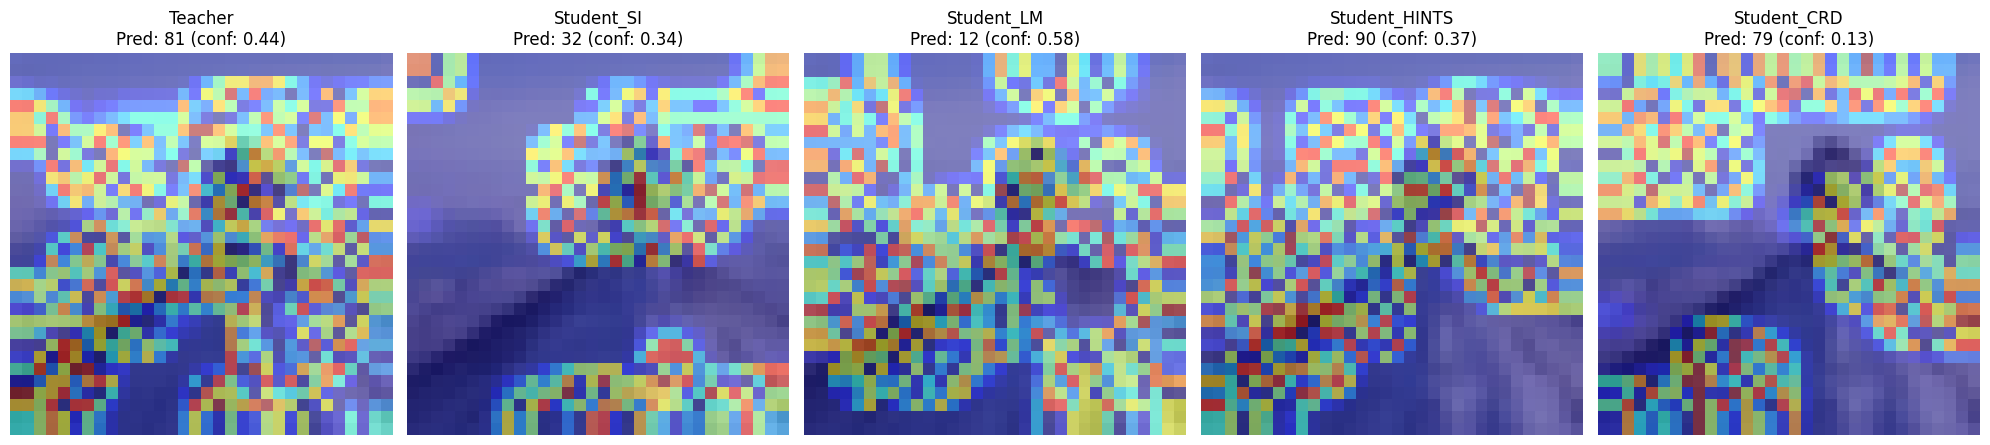


Image 2/5 - True Label: 92
Teacher: Using layer features.14
Teacher: class 79, confidence 0.999
Student_SI: Using layer features.8
Student_SI: class 6, confidence 0.791, similarity 0.492
Student_LM: Using layer features.8
Student_LM: class 79, confidence 0.766, similarity 0.567
Student_HINTS: Using layer features.8
Student_HINTS: class 6, confidence 0.503, similarity 0.618
Student_CRD: Using layer features.8
Student_CRD: class 79, confidence 0.905, similarity 0.546


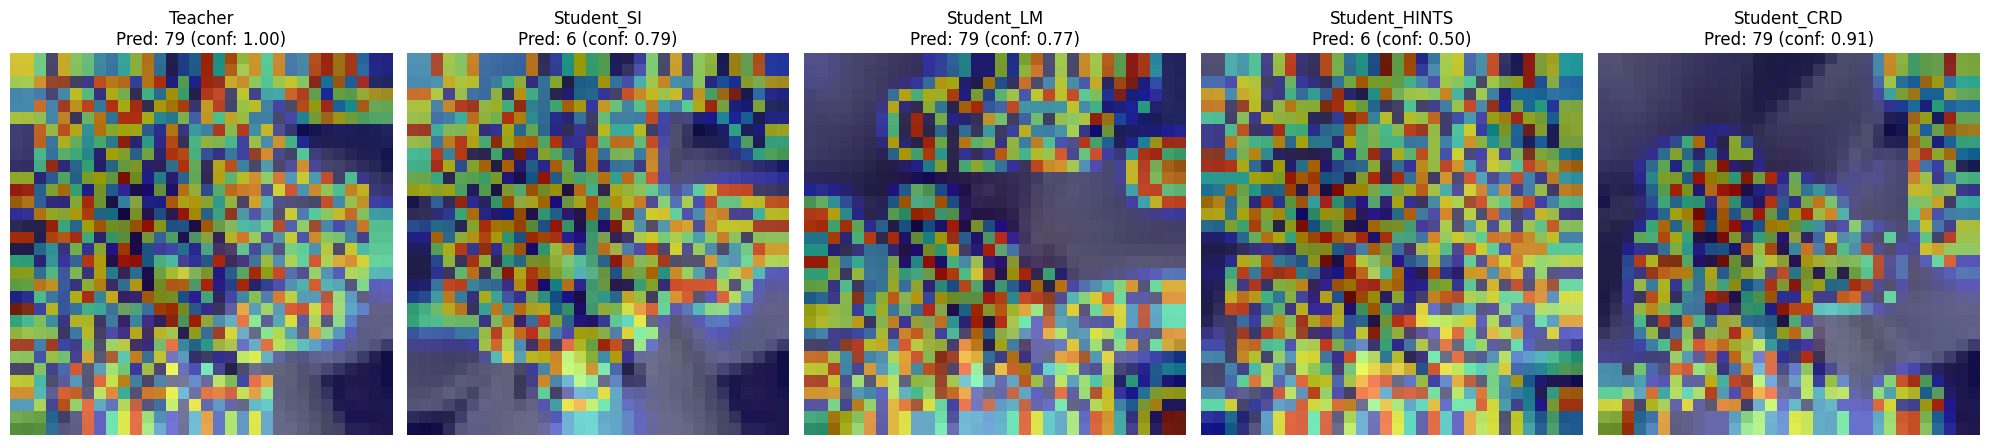


Image 3/5 - True Label: 71
Teacher: Using layer features.14
Teacher: class 33, confidence 0.623
Student_SI: Using layer features.8
Student_SI: class 12, confidence 0.889, similarity 0.507
Student_LM: Using layer features.8
Student_LM: class 12, confidence 0.954, similarity 0.397
Student_HINTS: Using layer features.8
Student_HINTS: class 76, confidence 0.789, similarity 0.681
Student_CRD: Using layer features.8
Student_CRD: class 12, confidence 0.891, similarity 0.475


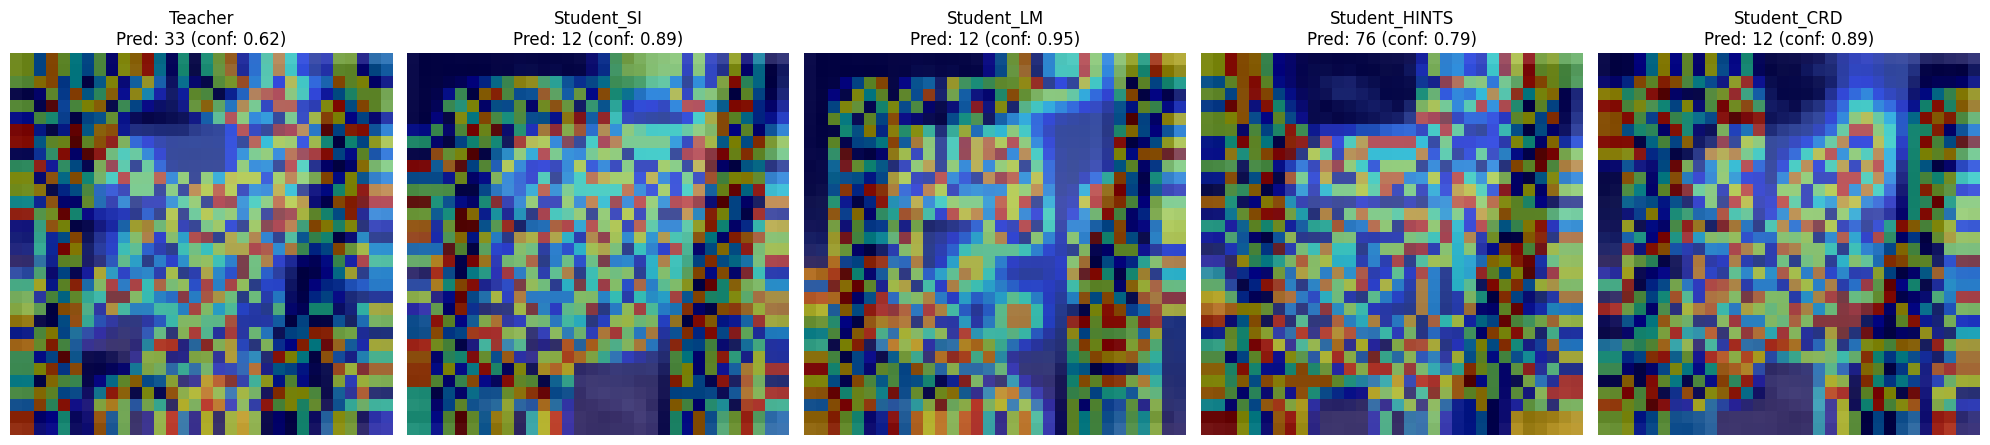


Image 4/5 - True Label: 43
Teacher: Using layer features.14
Teacher: class 43, confidence 1.000
Student_SI: Using layer features.8
Student_SI: class 43, confidence 1.000, similarity 0.751
Student_LM: Using layer features.8
Student_LM: class 43, confidence 1.000, similarity 0.723
Student_HINTS: Using layer features.8
Student_HINTS: class 43, confidence 1.000, similarity 0.804
Student_CRD: Using layer features.8
Student_CRD: class 43, confidence 1.000, similarity 0.694


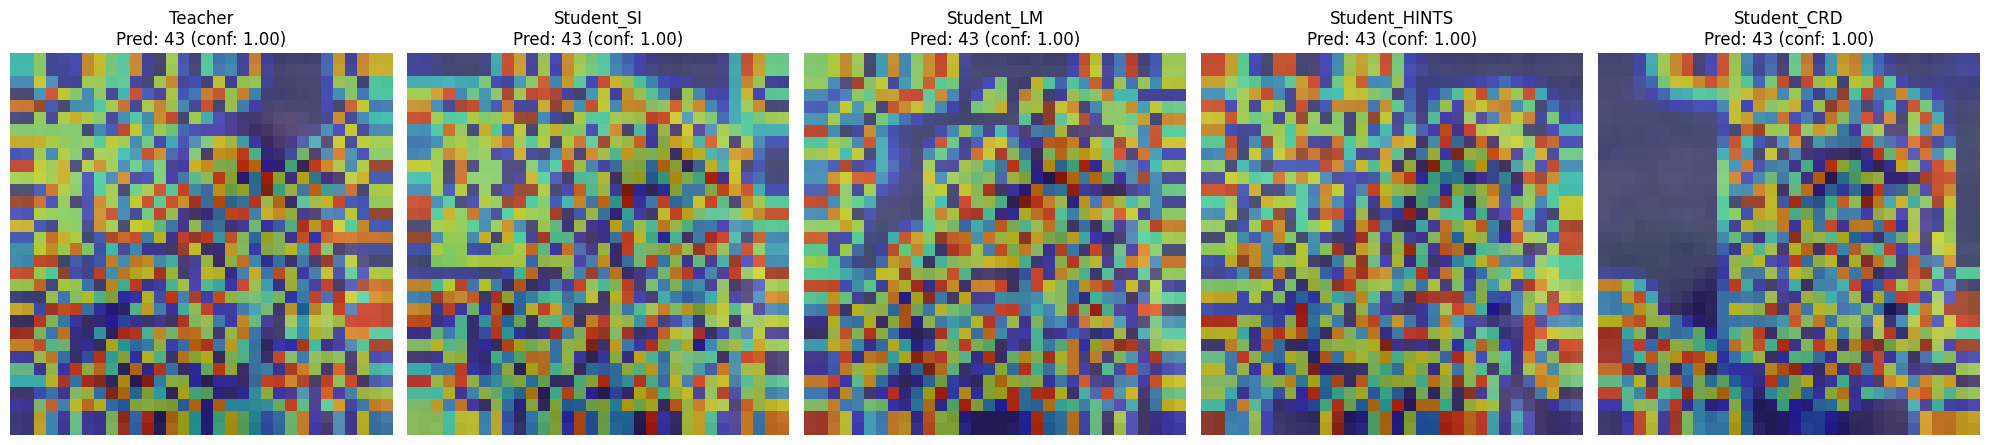


Image 5/5 - True Label: 70
Teacher: Using layer features.14
Teacher: class 70, confidence 1.000
Student_SI: Using layer features.8
Student_SI: class 70, confidence 1.000, similarity 0.742
Student_LM: Using layer features.8
Student_LM: class 70, confidence 1.000, similarity 0.503
Student_HINTS: Using layer features.8
Student_HINTS: class 70, confidence 1.000, similarity 0.863
Student_CRD: Using layer features.8
Student_CRD: class 70, confidence 1.000, similarity 0.668


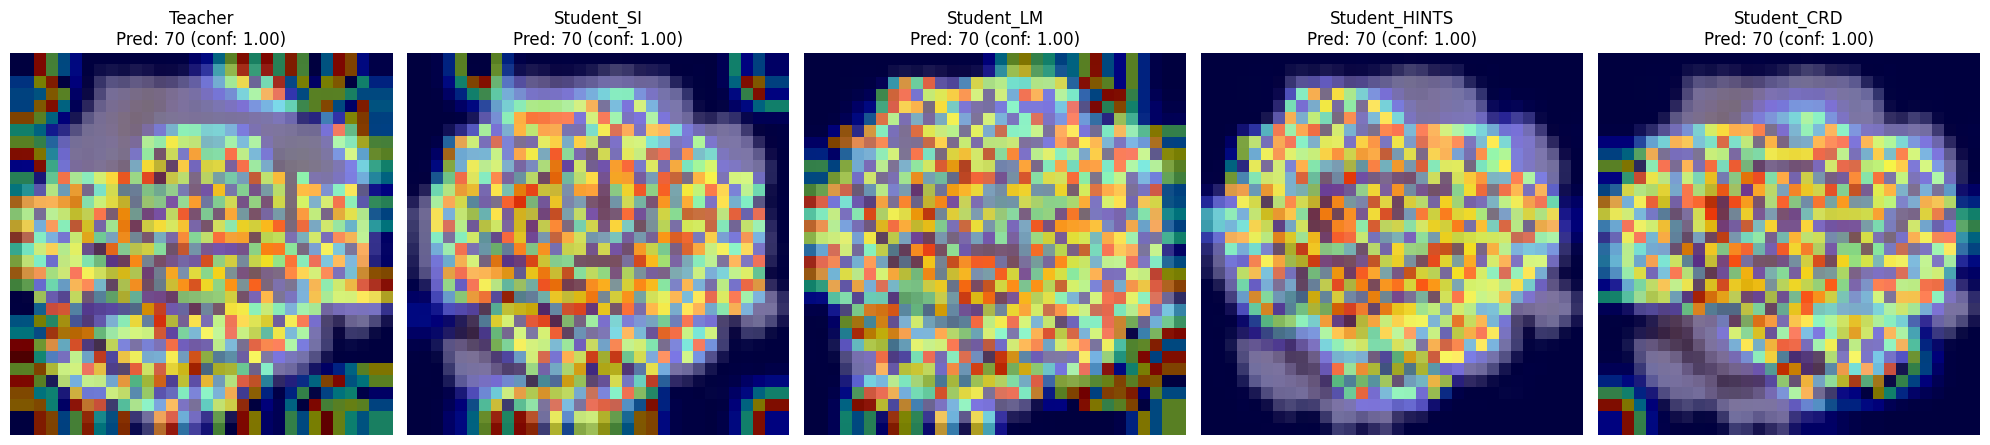


=== Average GradCAM Similarities to Teacher ===
Student_SI:
  Mean: 0.5911
  Std:  0.1275
  Min:  0.4640
  Max:  0.7506
Student_LM:
  Mean: 0.5240
  Std:  0.1157
  Min:  0.3967
  Max:  0.7229
Student_HINTS:
  Mean: 0.7323
  Std:  0.0885
  Min:  0.6181
  Max:  0.8627
Student_CRD:
  Mean: 0.5325
  Std:  0.1498
  Min:  0.2791
  Max:  0.6940

=== Model Architecture ===
Teacher: 13 Conv2d layers
Student_SI: 8 Conv2d layers
Student_LM: 8 Conv2d layers
Student_HINTS: 8 Conv2d layers
Student_CRD: 8 Conv2d layers


In [ ]:
# --- Fixed GradCAM visualization for KD models ---
!pip install torchcam --quiet
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load all models ----
teacher_ckpt = "/content/drive/MyDrive/vgg16_teacher_cifar100.pth"
student_SI_ckpt = "/content/drive/MyDrive/student_SI.pth"
student_LM_ckpt = "/content/drive/MyDrive/student_LM.pth"
student_HINTS_ckpt = "/content/drive/MyDrive/student_HINTS.pth"
student_CRD_ckpt = "/content/drive/MyDrive/student_CRD.pth"

teacher = make_teacher(pretrained=False).to(device)
student_SI = make_student().to(device)
student_LM = make_student().to(device)
student_HINTS = make_student().to(device)
student_CRD = make_student().to(device)

teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
student_SI.load_state_dict(torch.load(student_SI_ckpt, map_location=device))
student_LM.load_state_dict(torch.load(student_LM_ckpt, map_location=device))
student_HINTS.load_state_dict(torch.load(student_HINTS_ckpt, map_location=device))
student_CRD.load_state_dict(torch.load(student_CRD_ckpt, map_location=device))

teacher.eval(); student_SI.eval(); student_LM.eval(); student_HINTS.eval(); student_CRD.eval()

models = {
    "Teacher": teacher,
    "Student_SI": student_SI,
    "Student_LM": student_LM,
    "Student_HINTS": student_HINTS,
    "Student_CRD": student_CRD
}

# ---- Use CIFAR-100 normalization ----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])

testset = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
sample_indices = [0, 5, 10, 15, 20]
query_images = torch.stack([testset[i][0] for i in sample_indices])
query_labels = [testset[i][1] for i in sample_indices]

print(f"Image shape: {query_images[0].shape}")
print(f"Query labels: {query_labels}")

# ---- Improved GradCAM helper (MODIFIED) ----
def get_cam_heatmap(model, img_tensor, target_layer_name, model_name="Model"):
    """Generate GradCAM heatmap for a specific target layer"""

    # ---- MODIFIED SECTION: Find layer by name ----
    target_layer = None
    try:
        # Find the module corresponding to the given name
        for name, module in model.named_modules():
            if name == target_layer_name:
                target_layer = module
                break
    except Exception as e:
        print(f"{model_name}: Error finding layer '{target_layer_name}': {e}")
        return None, None, None

    if target_layer is None:
        print(f"{model_name}: Layer '{target_layer_name}' not found.")
        return None, None, None

    if not isinstance(target_layer, torch.nn.Conv2d):
         print(f"{model_name}: Layer '{target_layer_name}' is not a Conv2d layer.")
         return None, None, None

    print(f"{model_name}: Using layer {target_layer_name}")
    # ---- END MODIFIED SECTION ----

    try:
        # Create fresh CAM extractor for each call
        # Pass the found module (target_layer)
        cam_extractor = GradCAM(model, target_layer)

        # Get prediction
        img_input = img_tensor.unsqueeze(0).to(device)
        img_input.requires_grad = True

        output = model(img_input)
        class_idx = output.argmax(dim=1).item()
        pred_confidence = F.softmax(output, dim=1)[0, class_idx].item()

        # Generate activation map
        activation_map = cam_extractor(class_idx, output)

        if len(activation_map) == 0:
            print(f"{model_name}: Empty activation map")
            return None, None, None

        heatmap = activation_map[0].detach().cpu()

        # Handle shape
        while heatmap.dim() > 2:
            heatmap = heatmap.squeeze(0)

        # Normalize
        if heatmap.max() > heatmap.min():
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        else:
            heatmap = torch.zeros_like(heatmap)

        # Don't try to clear hooks - just let Python garbage collect
        del cam_extractor
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        return heatmap, class_idx, pred_confidence

    except Exception as e:
        print(f"{model_name}: Error generating CAM - {str(e)}")
        return None, None, None

# ---- Cosine similarity ----
def compute_cosine_similarity(map1, map2):
    if map1 is None or map2 is None:
        return 0.0
    map1_flat = map1.flatten().numpy()
    map2_flat = map2.flatten().numpy()
    return cosine_similarity(map1_flat.reshape(1, -1), map2_flat.reshape(1, -1))[0, 0]

# ---- Denormalize for visualization ----
def denormalize(tensor):
    """Denormalize tensor using CIFAR-100 stats"""
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)
    tensor = tensor.clone()
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# ---- Visualization (MODIFIED) ----

# 1. DEFINE YOUR TARGET LAYERS
# These layers are chosen because they are at the same
# conceptual depth (end of Block 3) and should have the
# same spatial resolution (likely 8x8), making them ideal for comparison.
target_layers = {
    "Teacher": "features.14",
    "Student_SI": "features.8",
    "Student_LM": "features.8",
    "Student_HINTS": "features.8",
    "Student_CRD": "features.8"
}

similarities = {name: [] for name in models if name != "Teacher"}

for idx, img in enumerate(query_images):
    print(f"\n{'='*80}")
    print(f"Image {idx+1}/{len(query_images)} - True Label: {query_labels[idx]}")
    print('='*80)

    fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

    # Denormalize image
    img_display = denormalize(img)
    img_pil = transforms.ToPILImage()(img_display)

    # Teacher GradCAM (MODIFIED)
    teacher_layer = target_layers["Teacher"]
    teacher_map, teacher_pred, teacher_conf = get_cam_heatmap(teacher, img, teacher_layer, "Teacher")

    if teacher_map is not None:
        # Resize heatmap to image size
        h, w = img_pil.size[1], img_pil.size[0]
        teacher_map_resized = F.interpolate(
            teacher_map.unsqueeze(0).unsqueeze(0),
            size=(h, w),
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        overlay = overlay_mask(
            img_pil,
            Image.fromarray(np.uint8(255 * teacher_map_resized)),
            alpha=0.5
        )
        axes[0].imshow(overlay)
        axes[0].set_title(f"Teacher\nPred: {teacher_pred} (conf: {teacher_conf:.2f})")
        print(f"Teacher: class {teacher_pred}, confidence {teacher_conf:.3f}")
    else:
        axes[0].imshow(img_pil)
        axes[0].set_title("Teacher (Error)")

    # Students (MODIFIED)
    for name, model in models.items():
        if name == "Teacher":
            continue

        # MODIFICATION: Get specific layer and pass it
        student_layer = target_layers[name]
        student_map, student_pred, student_conf = get_cam_heatmap(model, img, student_layer, name)

        ax_idx = list(models.keys()).index(name)

        if student_map is not None:
            h, w = img_pil.size[1], img_pil.size[0]
            student_map_resized = F.interpolate(
                student_map.unsqueeze(0).unsqueeze(0),
                size=(h, w),
                mode='bilinear',
                align_corners=False
            ).squeeze().numpy()

            overlay = overlay_mask(
                img_pil,
                Image.fromarray(np.uint8(255 * student_map_resized)),
                alpha=0.5
            )
            axes[ax_idx].imshow(overlay)
            axes[ax_idx].set_title(f"{name}\nPred: {student_pred} (conf: {student_conf:.2f})")

            # Compute similarity
            if teacher_map is not None:
                sim = compute_cosine_similarity(teacher_map, student_map)
                similarities[name].append(sim)
                print(f"{name}: class {student_pred}, confidence {student_conf:.3f}, similarity {sim:.3f}")
            else:
                print(f"{name}: class {student_pred}, confidence {student_conf:.3f}")
        else:
            axes[ax_idx].imshow(img_pil)
            axes[ax_idx].set_title(f"{name} (Error)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# ---- Results ----
print("\n" + "="*80)
print("=== Average GradCAM Similarities to Teacher ===")
print("="*80)
for name, sims in similarities.items():
    if len(sims) > 0:
        print(f"{name}:")
        print(f"  Mean: {np.mean(sims):.4f}")
        print(f"  Std:  {np.std(sims):.4f}")
        print(f"  Min:  {np.min(sims):.4f}")
        print(f"  Max:  {np.max(sims):.4f}")
    else:
        print(f"{name}: No valid similarities computed")

print("\n" + "="*80)
print("=== Model Architecture ===")
print("="*80)
for name, model in models.items():
    conv_layers = [(n, m) for n, m in model.named_modules() if isinstance(m, torch.nn.Conv2d)]
    print(f"{name}: {len(conv_layers)} Conv2d layers")

In [ ]:
print("--- Teacher Conv2d Layers ---")
for name, module in teacher.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(name)

print("\n--- Student (SI) Conv2d Layers ---")
for name, module in student_SI.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(name)

--- Teacher Conv2d Layers ---
features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28

--- Student (SI) Conv2d Layers ---
features.0
features.3
features.6
features.8
features.11
features.13
features.16
features.18


In [ ]:
# ====== Colab Cell: Color Invariance with CRD ======
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import copy, os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ---------- Reuse existing model constructors ----------
# make_teacher, make_student already defined above

# ---------- Load pretrained teacher (existing one) ----------
teacher_ckpt = '/content/drive/MyDrive/vgg16_teacher_cifar100.pth'
teacher = make_teacher(pretrained=False).to(device)
teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
print("Loaded base teacher.")

# ---------- Fine-tune teacher with color jitter augmentations ----------
transform_train_color = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset_color = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train_color)
train_loader_color = torch.utils.data.DataLoader(trainset_color, batch_size=128, shuffle=True, num_workers=2)

# validation loader (same as before)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# color-jittered test set (for invariance evaluation)
transform_test_color = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
testset_color = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test_color)
test_loader_color = torch.utils.data.DataLoader(testset_color, batch_size=128, shuffle=False, num_workers=2)

# ---------- Fine-tune the teacher ----------
def fine_tune_teacher(teacher, train_loader, test_loader, epochs=10, lr=1e-4):
    teacher = teacher.to(device)
    opt = optim.SGD(teacher.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    sched = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    best_acc = 0.0; best_state = None
    for ep in range(epochs):
        teacher.train()
        pbar = tqdm(train_loader, desc=f"ColorJitter Teacher Ep {ep+1}/{epochs}")
        total_loss = 0.0; n = 0
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = teacher(x)
            loss = F.cross_entropy(out, y)
            loss.backward(); opt.step()
            total_loss += loss.item() * x.size(0); n += x.size(0)
            pbar.set_postfix({'loss': total_loss / n})
        sched.step()
        acc = accuracy(test_loader, teacher)
        print(f"Val acc after ep {ep+1}: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(teacher.state_dict())
    if best_state:
        teacher.load_state_dict(best_state)
    return teacher

teacher_color = fine_tune_teacher(teacher, train_loader_color, test_loader)
torch.save(teacher_color.state_dict(), '/content/drive/MyDrive/vgg16_teacher_colorinvariant.pth')
print("Saved color-invariant teacher.")

# ---------- Train Student_SD (CRD) with this color-invariant teacher ----------
student_SD = make_student().to(device)
teacher_color.eval()

student_SD, acc_SD = train_student_CRD(
    student_SD, teacher_color, train_loader, test_loader,
    epochs=50, lr=1e-2, warmup=0, proj_dim=128, tau=0.2, crd_weight=1.0
)
torch.save(student_SD.state_dict(), '/content/drive/MyDrive/student_SD_colorCRD.pth')

# ---------- Evaluate color invariance ----------
print("\nEvaluating invariance on color-jittered test set:")
for name, model_ckpt in {
    "Teacher (base)": teacher_ckpt,
    "Teacher (color-invariant)": '/content/drive/MyDrive/vgg16_teacher_colorinvariant.pth',
    "Student_SI": '/content/drive/MyDrive/student_SI.pth',
    "Student_LM": '/content/drive/MyDrive/student_LM.pth',
    "Student_HINTS": '/content/drive/MyDrive/student_HINTS.pth',
    "Student_CRD": '/content/drive/MyDrive/student_CRD.pth',
    "Student_SD (color-CRD)": '/content/drive/MyDrive/student_SD_colorCRD.pth'
}.items():
    model = make_student() if "Student" in name else make_teacher()
    model.load_state_dict(torch.load(model_ckpt, map_location=device))
    model.to(device)
    acc_normal = accuracy(test_loader, model)
    acc_color = accuracy(test_loader_color, model)
    print(f"{name:30s} | Normal: {acc_normal:.4f} | Color-jittered: {acc_color:.4f}")


Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded base teacher.


ColorJitter Teacher Ep 1/10: 100%|██████████| 391/391 [00:51<00:00,  7.52it/s, loss=0.902]


Val acc after ep 1: 0.6798


ColorJitter Teacher Ep 2/10: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, loss=0.812]


Val acc after ep 2: 0.6792


ColorJitter Teacher Ep 3/10: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s, loss=0.78]


Val acc after ep 3: 0.6824


ColorJitter Teacher Ep 4/10: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s, loss=0.763]


Val acc after ep 4: 0.6816


ColorJitter Teacher Ep 5/10: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, loss=0.737]


Val acc after ep 5: 0.6817


ColorJitter Teacher Ep 6/10: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, loss=0.728]


Val acc after ep 6: 0.6813


ColorJitter Teacher Ep 7/10: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s, loss=0.725]


Val acc after ep 7: 0.6818


ColorJitter Teacher Ep 8/10: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s, loss=0.715]


Val acc after ep 8: 0.6825


ColorJitter Teacher Ep 9/10: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, loss=0.722]


Val acc after ep 9: 0.6843


ColorJitter Teacher Ep 10/10: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s, loss=0.721]


Val acc after ep 10: 0.6828
Saved color-invariant teacher.


CRD Ep 1/50: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s, loss=8.01, crd=2.79]


CRD epoch 1 val_acc: 0.1074


CRD Ep 2/50: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s, loss=6.58, crd=2.46]


CRD epoch 2 val_acc: 0.1481


CRD Ep 3/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=5.98, crd=1.96]


CRD epoch 3 val_acc: 0.1999


CRD Ep 4/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=5.51, crd=1.83]


CRD epoch 4 val_acc: 0.2308


CRD Ep 5/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=5.08, crd=1.72]


CRD epoch 5 val_acc: 0.3065


CRD Ep 6/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=4.69, crd=1.57]


CRD epoch 6 val_acc: 0.3410


CRD Ep 7/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=4.41, crd=1.44]


CRD epoch 7 val_acc: 0.3811


CRD Ep 8/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=4.15, crd=1.33]


CRD epoch 8 val_acc: 0.3991


CRD Ep 9/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=3.95, crd=1.43]


CRD epoch 9 val_acc: 0.4300


CRD Ep 10/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=3.77, crd=1.34]


CRD epoch 10 val_acc: 0.4663


CRD Ep 11/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=3.61, crd=1.43]


CRD epoch 11 val_acc: 0.4558


CRD Ep 12/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=3.47, crd=1.25]


CRD epoch 12 val_acc: 0.4823


CRD Ep 13/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=3.38, crd=1.23]


CRD epoch 13 val_acc: 0.4927


CRD Ep 14/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=3.25, crd=1.33]


CRD epoch 14 val_acc: 0.5079


CRD Ep 15/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=3.15, crd=1.27]


CRD epoch 15 val_acc: 0.5146


CRD Ep 16/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=3.07, crd=1.1]


CRD epoch 16 val_acc: 0.5291


CRD Ep 17/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=2.98, crd=1.14]


CRD epoch 17 val_acc: 0.5399


CRD Ep 18/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.92, crd=1.18]


CRD epoch 18 val_acc: 0.5416


CRD Ep 19/50: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s, loss=2.84, crd=1.12]


CRD epoch 19 val_acc: 0.5505


CRD Ep 20/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.77, crd=0.994]


CRD epoch 20 val_acc: 0.5521


CRD Ep 21/50: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s, loss=2.7, crd=1.1]


CRD epoch 21 val_acc: 0.5650


CRD Ep 22/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.65, crd=1.05]


CRD epoch 22 val_acc: 0.5704


CRD Ep 23/50: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s, loss=2.6, crd=1.04]


CRD epoch 23 val_acc: 0.5723


CRD Ep 24/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.54, crd=1.09]


CRD epoch 24 val_acc: 0.5772


CRD Ep 25/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.5, crd=1.09]


CRD epoch 25 val_acc: 0.5758


CRD Ep 26/50: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s, loss=2.45, crd=1.04]


CRD epoch 26 val_acc: 0.5793


CRD Ep 27/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=2.4, crd=1.02]


CRD epoch 27 val_acc: 0.5835


CRD Ep 28/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=2.37, crd=1.07]


CRD epoch 28 val_acc: 0.5933


CRD Ep 29/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=2.32, crd=1]


CRD epoch 29 val_acc: 0.5964


CRD Ep 30/50: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s, loss=2.3, crd=1.1]


CRD epoch 30 val_acc: 0.5884


CRD Ep 31/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.9, crd=0.918]


CRD epoch 31 val_acc: 0.6297


CRD Ep 32/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.8, crd=0.921]


CRD epoch 32 val_acc: 0.6332


CRD Ep 33/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.76, crd=0.892]


CRD epoch 33 val_acc: 0.6358


CRD Ep 34/50: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s, loss=1.73, crd=0.943]


CRD epoch 34 val_acc: 0.6349


CRD Ep 35/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.71, crd=0.82]


CRD epoch 35 val_acc: 0.6374


CRD Ep 36/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.68, crd=0.884]


CRD epoch 36 val_acc: 0.6380


CRD Ep 37/50: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s, loss=1.66, crd=0.833]


CRD epoch 37 val_acc: 0.6353


CRD Ep 38/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.64, crd=0.824]


CRD epoch 38 val_acc: 0.6389


CRD Ep 39/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.62, crd=0.833]


CRD epoch 39 val_acc: 0.6361


CRD Ep 40/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.61, crd=0.833]


CRD epoch 40 val_acc: 0.6370


CRD Ep 41/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.59, crd=0.867]


CRD epoch 41 val_acc: 0.6396


CRD Ep 42/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.57, crd=0.876]


CRD epoch 42 val_acc: 0.6401


CRD Ep 43/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.56, crd=0.802]


CRD epoch 43 val_acc: 0.6395


CRD Ep 44/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.55, crd=0.794]


CRD epoch 44 val_acc: 0.6422


CRD Ep 45/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.54, crd=0.856]


CRD epoch 45 val_acc: 0.6405


CRD Ep 46/50: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s, loss=1.53, crd=0.836]


CRD epoch 46 val_acc: 0.6390


CRD Ep 47/50: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s, loss=1.51, crd=0.798]


CRD epoch 47 val_acc: 0.6417


CRD Ep 48/50: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s, loss=1.5, crd=0.831]


CRD epoch 48 val_acc: 0.6417


CRD Ep 49/50: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s, loss=1.48, crd=0.834]


CRD epoch 49 val_acc: 0.6391


CRD Ep 50/50: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s, loss=1.47, crd=0.855]


CRD epoch 50 val_acc: 0.6390

Evaluating invariance on color-jittered test set:


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Teacher (base)                 | Normal: 0.6784 | Color-jittered: 0.5944
Teacher (color-invariant)      | Normal: 0.6843 | Color-jittered: 0.6475
Student_SI                     | Normal: 0.6216 | Color-jittered: 0.5134
Student_LM                     | Normal: 0.6406 | Color-jittered: 0.5502
Student_HINTS                  | Normal: 0.6773 | Color-jittered: 0.5962
Student_CRD                    | Normal: 0.6416 | Color-jittered: 0.5382
Student_SD (color-CRD)         | Normal: 0.6422 | Color-jittered: 0.5526


In [ ]:
# ===== Compare VGG-16 vs VGG-19 teachers using Logit Matching =====
import torchvision.models as models

# ---------- SETTINGS ----------
BATCH_SIZE = 128
EPOCHS_STUDENT = 50
LR_STUDENT = 1e-2
ALPHA_KD = 0.9
TEMPERATURE_KD = 4.0
NUM_CLASSES = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- Load data (reuse CIFAR-100 loaders) ----------
# train_loader, test_loader already exist from previous cell

# ---------- Model constructors ----------
def make_teacher_vgg19(num_classes=NUM_CLASSES, pretrained=True):
    t = models.vgg19(pretrained=pretrained)
    in_f = t.classifier[-1].in_features
    t.classifier[-1] = nn.Linear(in_f, num_classes)
    return t

def make_student_vgg11(num_classes=NUM_CLASSES, pretrained=False):
    s = models.vgg11(pretrained=pretrained)
    in_f = s.classifier[-1].in_features
    s.classifier[-1] = nn.Linear(in_f, num_classes)
    return s

# ---------- Load VGG-16 teacher (already trained) ----------
VGG16_CKPT = '/content/drive/MyDrive/vgg16_teacher_cifar100.pth'
teacher16 = make_teacher(pretrained=True).to(DEVICE)
teacher16.load_state_dict(torch.load(VGG16_CKPT, map_location=DEVICE))
teacher16.eval()
for p in teacher16.parameters(): p.requires_grad=False

# ---------- Load or train VGG-19 teacher ----------
VGG19_CKPT = '/content/drive/MyDrive/vgg19_teacher_cifar100.pth'
teacher19 = make_teacher_vgg19(pretrained=True).to(DEVICE)
if os.path.isfile(VGG19_CKPT):
    teacher19.load_state_dict(torch.load(VGG19_CKPT, map_location=DEVICE))
    print("Loaded VGG-19 teacher checkpoint.")
else:
    # Optional: train from scratch/finetune VGG-19
    print("Training VGG-19 teacher from scratch...")
    teacher19, acc = train_teacher(teacher19, train_loader, test_loader, epochs=25, lr=1e-3)
    torch.save(teacher19.state_dict(), VGG19_CKPT)
teacher19.eval()
for p in teacher19.parameters(): p.requires_grad=False

# ---------- Train student with Logit Matching ----------
def train_student_LM_simple(student, teacher, train_loader, test_loader, epochs=EPOCHS_STUDENT,
                            lr=LR_STUDENT, alpha=ALPHA_KD, T=TEMPERATURE_KD):
    student = student.to(DEVICE)
    teacher = teacher.to(DEVICE)
    for p in teacher.parameters(): p.requires_grad=False
    opt = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    sched = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
    best_acc=0.0; best_state=None
    for ep in range(epochs):
        student.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"LM Ep {ep+1}/{epochs}")
        for x, y in pbar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            s_logits = student(x)
            with torch.no_grad():
                t_logits = teacher(x)
            ce = F.cross_entropy(s_logits, y)
            kd_l = vanilla_kd_loss(s_logits, t_logits, T=T)
            loss = (1.0 - alpha) * ce + alpha * kd_l
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            pbar.set_postfix({'loss': running_loss/((pbar.n+1)*train_loader.batch_size)})
        sched.step()
        val = accuracy(test_loader, student)
        print(f"Epoch {ep+1}: val_acc={val:.4f}")
        if val>best_acc:
            best_acc=val
            best_state=copy.deepcopy(student.state_dict())
    if best_state is not None:
        student.load_state_dict(best_state)
    return student, best_acc

# ---------- Run distillation experiments ----------
# Student w/ VGG-16 teacher
# student16 = make_student_vgg11().to(DEVICE)
# student16, acc16 = train_student_LM_simple(student16, teacher16, train_loader, test_loader)
# print(f"Student distilled from VGG-16 teacher: val_acc={acc16:.4f}")

# Student w/ VGG-19 teacher
student19 = make_student_vgg11().to(DEVICE)
student19, acc19 = train_student_LM_simple(student19, teacher19, train_loader, test_loader)
print(f"Student distilled from VGG-19 teacher: val_acc={acc19:.4f}")

# ---------- Summary ----------
# print("===== Summary =====")
# print(f"Student (VGG-16 teacher): {acc16:.4f}")
print(f"Student (VGG-19 teacher): {acc19:.4f}")


Training VGG-19 teacher from scratch...


Teacher Ep 1/25: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=3.01]


Teacher epoch 1 val_acc: 0.4455


Teacher Ep 2/25: 100%|██████████| 391/391 [00:44<00:00,  8.76it/s, loss=2.02]


Teacher epoch 2 val_acc: 0.5276


Teacher Ep 3/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=1.75]


Teacher epoch 3 val_acc: 0.5530


Teacher Ep 4/25: 100%|██████████| 391/391 [00:44<00:00,  8.84it/s, loss=1.58]


Teacher epoch 4 val_acc: 0.5793


Teacher Ep 5/25: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s, loss=1.47]


Teacher epoch 5 val_acc: 0.5845


Teacher Ep 6/25: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s, loss=1.37]


Teacher epoch 6 val_acc: 0.6065


Teacher Ep 7/25: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s, loss=1.29]


Teacher epoch 7 val_acc: 0.6164


Teacher Ep 8/25: 100%|██████████| 391/391 [00:44<00:00,  8.75it/s, loss=1.22]


Teacher epoch 8 val_acc: 0.6336


Teacher Ep 9/25: 100%|██████████| 391/391 [00:44<00:00,  8.80it/s, loss=1.16]


Teacher epoch 9 val_acc: 0.6197


Teacher Ep 10/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=1.11]


Teacher epoch 10 val_acc: 0.6380


Teacher Ep 11/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=1.05]


Teacher epoch 11 val_acc: 0.6386


Teacher Ep 12/25: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s, loss=1.01]


Teacher epoch 12 val_acc: 0.6460


Teacher Ep 13/25: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s, loss=0.965]


Teacher epoch 13 val_acc: 0.6519


Teacher Ep 14/25: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s, loss=0.923]


Teacher epoch 14 val_acc: 0.6466


Teacher Ep 15/25: 100%|██████████| 391/391 [00:44<00:00,  8.80it/s, loss=0.876]


Teacher epoch 15 val_acc: 0.6572


Teacher Ep 16/25: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s, loss=0.848]


Teacher epoch 16 val_acc: 0.6521


Teacher Ep 17/25: 100%|██████████| 391/391 [00:44<00:00,  8.80it/s, loss=0.812]


Teacher epoch 17 val_acc: 0.6669


Teacher Ep 18/25: 100%|██████████| 391/391 [00:44<00:00,  8.80it/s, loss=0.777]


Teacher epoch 18 val_acc: 0.6653


Teacher Ep 19/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=0.743]


Teacher epoch 19 val_acc: 0.6590


Teacher Ep 20/25: 100%|██████████| 391/391 [00:44<00:00,  8.79it/s, loss=0.724]


Teacher epoch 20 val_acc: 0.6648


Teacher Ep 21/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=0.685]


Teacher epoch 21 val_acc: 0.6703


Teacher Ep 22/25: 100%|██████████| 391/391 [00:44<00:00,  8.79it/s, loss=0.661]


Teacher epoch 22 val_acc: 0.6745


Teacher Ep 23/25: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s, loss=0.631]


Teacher epoch 23 val_acc: 0.6691


Teacher Ep 24/25: 100%|██████████| 391/391 [00:44<00:00,  8.76it/s, loss=0.617]


Teacher epoch 24 val_acc: 0.6692


Teacher Ep 25/25: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s, loss=0.58]


Teacher epoch 25 val_acc: 0.6734


LM Ep 1/50: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s, loss=9.76]


Epoch 1: val_acc=0.0621


LM Ep 2/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=8.35]


Epoch 2: val_acc=0.1121


LM Ep 3/50: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=7.32]


Epoch 3: val_acc=0.1698


LM Ep 4/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=6.24]


Epoch 4: val_acc=0.2443


LM Ep 5/50: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s, loss=5.36]


Epoch 5: val_acc=0.2669


LM Ep 6/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=4.71]


Epoch 6: val_acc=0.3311


LM Ep 7/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=4.15]


Epoch 7: val_acc=0.3631


LM Ep 8/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=3.7]


Epoch 8: val_acc=0.3943


LM Ep 9/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=3.39]


Epoch 9: val_acc=0.4222


LM Ep 10/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=3.13]


Epoch 10: val_acc=0.4641


LM Ep 11/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=2.88]


Epoch 11: val_acc=0.4650


LM Ep 12/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=2.7]


Epoch 12: val_acc=0.4858


LM Ep 13/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=2.53]


Epoch 13: val_acc=0.5011


LM Ep 14/50: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s, loss=2.39]


Epoch 14: val_acc=0.4970


LM Ep 15/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=2.24]


Epoch 15: val_acc=0.5170


LM Ep 16/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=2.11]


Epoch 16: val_acc=0.5261


LM Ep 17/50: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s, loss=2.02]


Epoch 17: val_acc=0.5335


LM Ep 18/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=1.96]


Epoch 18: val_acc=0.5491


LM Ep 19/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=1.85]


Epoch 19: val_acc=0.5548


LM Ep 20/50: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s, loss=1.8]


Epoch 20: val_acc=0.5503


LM Ep 21/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=1.74]


Epoch 21: val_acc=0.5678


LM Ep 22/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=1.68]


Epoch 22: val_acc=0.5704


LM Ep 23/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=1.61]


Epoch 23: val_acc=0.5754


LM Ep 24/50: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=1.57]


Epoch 24: val_acc=0.5816


LM Ep 25/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=1.53]


Epoch 25: val_acc=0.5802


LM Ep 26/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=1.5]


Epoch 26: val_acc=0.5865


LM Ep 27/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=1.45]


Epoch 27: val_acc=0.5907


LM Ep 28/50: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s, loss=1.41]


Epoch 28: val_acc=0.5986


LM Ep 29/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=1.38]


Epoch 29: val_acc=0.5914


LM Ep 30/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=1.34]


Epoch 30: val_acc=0.5920


LM Ep 31/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=1.11]


Epoch 31: val_acc=0.6217


LM Ep 32/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=1.05]


Epoch 32: val_acc=0.6268


LM Ep 33/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=1.02]


Epoch 33: val_acc=0.6283


LM Ep 34/50: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=1.01]


Epoch 34: val_acc=0.6297


LM Ep 35/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=0.995]


Epoch 35: val_acc=0.6271


LM Ep 36/50: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=0.984]


Epoch 36: val_acc=0.6318


LM Ep 37/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=0.972]


Epoch 37: val_acc=0.6301


LM Ep 38/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=0.96]


Epoch 38: val_acc=0.6313


LM Ep 39/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=0.961]


Epoch 39: val_acc=0.6322


LM Ep 40/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=0.95]


Epoch 40: val_acc=0.6329


LM Ep 41/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=0.942]


Epoch 41: val_acc=0.6344


LM Ep 42/50: 100%|██████████| 391/391 [00:44<00:00,  8.75it/s, loss=0.932]


Epoch 42: val_acc=0.6345


LM Ep 43/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=0.921]


Epoch 43: val_acc=0.6333


LM Ep 44/50: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=0.921]


Epoch 44: val_acc=0.6354


LM Ep 45/50: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=0.91]


Epoch 45: val_acc=0.6376


LM Ep 46/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.91]


Epoch 46: val_acc=0.6380


LM Ep 47/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.904]


Epoch 47: val_acc=0.6359


LM Ep 48/50: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=0.897]


Epoch 48: val_acc=0.6344


LM Ep 49/50: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=0.896]


Epoch 49: val_acc=0.6366


LM Ep 50/50: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.889]


Epoch 50: val_acc=0.6364
Student distilled from VGG-19 teacher: val_acc=0.6380
Student (VGG-19 teacher): 0.6380
